## Creating a logistic regression model in Python!

In [1]:
# Reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Logistic%20Regression%20balanced.ipynb

### Import necessary libraries:

In [322]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

plt.rc("font", size=14) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from mpl_toolkits.basemap import Basemap


import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

#Read data from a local csv file:

##Will change this to scrape files from the Smartfin.org website later.
#data = pd.read_csv('Motion_13735.CSV', header=0)   
#data = data.dropna()

#Print out the column headings:
#print(data.shape)
#print(list(data.columns))

### Summary of specific ride IDs:

In [323]:
ride_ids_array = ['15629', '15669', '15692', '15686', '15962', '15963', '15971', '15972']


#ride_ids = ['15629']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)
# 15218 - Jasmine's Second Ride Sesh filmed with GoPro (Aug 29) //no footage
# 15629 - Jasmine's First Ride Sesh filmed with VIRB (Oct. 24) //first labelled footage!
# 15669 - Jasmine's Second Ride Sesh filmed with VIRB (Nov. 7) //second labelled footage!
# 15692 - Jasmine's 3rd Ride Sesh filmed with VIRB (Nov. 9) //third labelled footage!
# 15686 - Jasmine's 4th Ride Sesh filmed with VIRB (Nov. 11) //fourth labelled footage!
# 15962 - Rachelle's 1st Ride Sesh filmed with VIRB (Nov. 11) //5th labelled footage!
# 15963 - Jasmine's 5th Ride Sesh filmed with VIRB (Nov. 11) //6th labelled footage!
# 15971 - Mexico Sesh filmed with VIRB (Nov. 11) //7th labelled footage!
# 15972 - Jasmine's 7th Ride Sesh filmed with VIRB (Nov. 11) //8th labelled footage!


## Fin ID Scraper (pulls dataframes for specific ride id from website):

In [324]:
#%% Fin ID scraper

def create_ride_from_id():
    # Input fin ID, get all ride IDs
    # base URL to which we'll append given fin IDs
    fin_url_base = 'http://surf.smartfin.org/fin/'

    # Look for the following text in the HTML contents in fcn below
    str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
    str_id_date = 'var date = \'' # backslash allows us to look for single quote

    #%% Ride ID scraper
    # Input ride ID, get ocean and motion CSVs
    # Base URL to which we'll append given ride IDs
    ride_url_base = 'https://surf.smartfin.org/ride/'

    # Look for the following text in the HTML contents in fcn below
    str_id_csv = 'img id="temperatureChart" class="chart" src="' 

    def get_csv_from_ride_id(rid):
        # Build URL for each individual ride
        ride_url = ride_url_base+str(rid)
        print(ride_url)

        # Get contents of ride_url
        html_contents = requests.get(ride_url).text

        # Find CSV identifier 
        loc_csv_id = html_contents.find(str_id_csv)

        # Different based on whether user logged in with FB or Google
        offset_googleOAuth = [46, 114]
        offset_facebkOAuth = [46, 112]
        if html_contents[loc_csv_id+59] == 'f': # Facebook login
            off0 = offset_facebkOAuth[0]
            off1 = offset_facebkOAuth[1]
        else: # Google login
            off0 = offset_googleOAuth[0]
            off1 = offset_googleOAuth[1]

        csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]

    #    print(csv_id_longstr)

        # Stitch together full URL for CSV
        if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything

            ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
            motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'

            print(ocean_csv_url)
            # Go to ocean_csv_url and grab contents (theoretically, a CSV)
            ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
            elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
            ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')

            motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])

            # Reindex on timestamp if there are at least a few rows
            if len(ocean_df_small) > 1:
                ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
                motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)

                #print(ocean_df_small)
                #print(motion_df_small)

                #May need to change this sampling interval:
                sample_interval = '33ms'


                ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
                motion_df_small_resample = motion_df_small.resample(sample_interval).mean()

                # No need to save many extra rows with no fix
                motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]

                return ocean_df_small_resample, motion_df_small_resample

        else:
            ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
            motion_df_small_resample = pd.DataFrame() 
            return ocean_df_small_resample, motion_df_small_resample

    appended_ocean_list = [] # list of DataFrames from original CSVs
    appended_motion_list = []
    appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

    ## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
    ## (Here, ride IDS are either ocean or motion dataframes)
    count_good_fins = 0

    # Loop over ride_ids and find CSVs
    for rid in ride_ids:
        try:
            new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
            #print(len(new_ocean_df))
            #print(len(new_motion_df))
            if not new_ocean_df.empty: # Calibration rides, for example
                # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
                appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
                appended_ocean_list.append(new_ocean_df)
                appended_motion_list.append(new_motion_df)
                print("Ride data has been uploaded.")
                #print("Ride: ", rid, "data has been uploaded.")
                count_good_fins += 1

        except: 
            print("Ride threw an exception!")
            #print("Ride ", rid, "threw an exception!")    

    #%% Build the "Master" DataFrame

    # appended_ocean_df.summary()
    df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
    ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
    motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])



    #print(motion_df)
    
    
    ##Drop the NA values from the dataframe: 
    motion_df_dropped = motion_df.drop(columns=['Latitude', 'Longitude'])
    motion_df_dropped = motion_df_dropped.dropna(axis=0, how='any')
    #print(motion_df_dropped)
    
    #Create an elapsed_timedelta field:
    motion_df_dropped['TimeDelta'] = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
    motion_df_dropped.head(10)
    
    return motion_df_dropped
    

## Create dictionary to store {ride_id, dataframe}:

In [325]:
#ride_ids_array = ['15629', '15669', '15692', '15686', '15962', '15963', '15971', '15972']

dataframe_collection = {} 

for ride in ride_ids_array:
    ride_ids = [ride]
    dataframe_collection.update({ride:create_ride_from_id()})
    

https://surf.smartfin.org/ride/15629
https://surf.smartfin.org/media/201810/google_105349665704999793400_0006667E229D_181031013846_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15669
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181107203025_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15692
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181109191556_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15686
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181111203352_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15962
https://surf.smartfin.org/media/201902/google_105349665704999793400_0006667E229D_190208171724_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15963
https://surf.smartfin.org/media/201902/google_105349665704999793400_0006667E229D_190222184248_Ocean.CSV
Ride data

## Print to check dataframe collection:

In [348]:
print(dataframe_collection['15629'].head(10))

                                       Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                   
15629   2018-10-31 19:33:01.839  11992061.0    -6.0   540.0    47.0   -24.0   
        2018-10-31 19:33:02.103  11992311.0     4.0   514.0    93.0    10.0   
        2018-10-31 19:33:02.334  11992561.0    14.0   532.0   126.0    40.0   
        2018-10-31 19:33:02.598  11992813.0    13.0   528.0   133.0   -72.0   
        2018-10-31 19:33:02.829  11993063.0    23.0   481.0   121.0   -30.0   
        2018-10-31 19:33:03.093  11993313.0    24.0   452.0   105.0    74.0   
        2018-10-31 19:33:03.357  11993564.0    10.0   467.0    39.0    33.0   
        2018-10-31 19:33:03.588  11993815.0    -5.0   490.0    60.0  -151.0   
        2018-10-31 19:33:03.852  11994065.0    16.0   475.0    94.0  -117.0   
        2018-10-31 19:33:04.116  11994316.0   -17.0   461.0    38.0   -34.0   

                                 IMU G2  IMU G3  IM

In [225]:
print(dataframe_collection['15972'].head(10))

                                        Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                    
15972   2019-02-25 01:31:59.613  400259893.0   101.0   562.0    71.0   241.0   
        2019-02-25 01:31:59.877  400260143.0   -44.0   311.0   104.0    89.0   
        2019-02-25 01:32:00.108  400260394.0   -32.0   606.0    80.0  -132.0   
        2019-02-25 01:32:00.372  400260644.0     8.0   537.0   102.0  -112.0   
        2019-02-25 01:32:00.636  400260896.0   -70.0   406.0    99.0   -17.0   
        2019-02-25 01:32:00.867  400261145.0   -69.0   469.0    75.0   175.0   
        2019-02-25 01:32:01.131  400261395.0   -67.0   475.0    82.0   111.0   
        2019-02-25 01:32:01.362  400261646.0   -63.0   495.0    70.0   -13.0   
        2019-02-25 01:32:01.626  400261896.0   -60.0   499.0    84.0   -12.0   
        2019-02-25 01:32:01.890  400262147.0   -59.0   484.0    78.0   -46.0   

                                 IMU G2

## Footage sync code written by Alina, edited by Jasmine:

In [373]:
import time

def label_complex_data(footage_file, pd_dataframe, sync_threshold = 20000):
    #First, perform sync
    sync_buf = 0
    with open(footage_file) as file:
        for line in file:
            labelled_time = line.split(None, 2) 
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip()
            if labelled_time[1].lower() == 'sync': #Assumption that first word in sync line is "sync"
                sync_time = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000
                index = 0
                start = 0
                end = 0
                #Syncing occurs when IMU A2 data is negative for a longer period than the provided threshold
                #Default is 20 seconds
                for data in pd_dataframe['IMU A2']:
                    if data < 0 and start == 0:
                        start = pd_dataframe['TimeDelta'][index]
                    elif data > 0 and start != 0:
                        end = pd_dataframe['TimeDelta'][index]
                        if end - start > sync_threshold:
                            sync_buf = start - sync_time
                            break
                        start = 0
                    index += 1
                    
                    
    #Create new DataFrame containing label info
    accepted_labels = set()
    accepted_labels = {'SYNC', 'WALKING IN WATER', 'PUSH-OFF', 'PADDLING INTO WAVES', 'DISCARD', 'SIT-UP', 'FLOATING', "TURNING TO SURFER'S LEFT", 'LAY-DOWN', 'PADDLING FOR A WAVE', 'SIT-BACK', 'NEW', 'POP-UP', 'SURFING', 'WIPE-OUT', "TURNING TO SURFER'S RIGHT", 'FLIP BOARD RIGHT-SIDE UP', 'PULL-BACK LEASH', 'PADDLING FOR POSITION', 'STEP-OFF', 'DONE'}
    label_frame = pd.DataFrame(0, index = pd_dataframe.index, columns = accepted_labels)
    for label in accepted_labels:
        label_frame[label] = [0] * len(pd_dataframe['Time'])

    
    #Convention of labelled footage text: "MINUTE:SECOND LABEL"
    elapsed_time = 0
    cur_label = ''
    buffer = 0
    with open(footage_file) as file:
        for line in file:
            labelled_time = line.split(None, 1) #complex requires the entire label
                
            #If the first word is not a properly formatted time, the line cannot be read
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
                cur_timeMS = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000 + sync_buf
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip() #Remove potential newline
                
            #Check for end of video and modify buffer accordingly
            if labelled_time[1].lower() == 'new': #Assumption that label end video with "new"
                buffer += cur_timeMS
                
                
            if labelled_time[1].upper() in accepted_labels:
                while (elapsed_time < len(pd_dataframe['Time']) and
                      (np.isnan(pd_dataframe['TimeDelta'][elapsed_time]) or
                       pd_dataframe['TimeDelta'][elapsed_time] < cur_timeMS + buffer)):
                    if cur_label != '':
                        label_frame[cur_label][elapsed_time] = 1
                    elapsed_time += 1
                if labelled_time[1].upper() != 'NEW':
                    cur_label = labelled_time[1].upper()

    labelled = pd.concat([pd_dataframe, label_frame], axis = 1)

    return labelled

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000

#motion_df_simple = label_data('Footage3.txt')
#print(motion_df_simple.size)
#motion_df_simple.head(10)

In [388]:
#Test one before doing all: 
labelled_df = label_complex_data(ftf, dataframe_collection['15629'], sync_threshold = 20000)
list(labelled_df)

#new_labelled_df = pd.concat([dataframe_collection['15629'], labelled_df, axis = 1)
labelled_df.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                   
15629   2018-10-31 19:33:01.839  11992061.0    -6.0   540.0    47.0   -24.0   
        2018-10-31 19:33:02.103  11992311.0     4.0   514.0    93.0    10.0   
        2018-10-31 19:33:02.334  11992561.0    14.0   532.0   126.0    40.0   
        2018-10-31 19:33:02.598  11992813.0    13.0   528.0   133.0   -72.0   
        2018-10-31 19:33:02.829  11993063.0    23.0   481.0   121.0   -30.0   
        2018-10-31 19:33:03.093  11993313.0    24.0   452.0   105.0    74.0   
        2018-10-31 19:33:03.357  11993564.0    10.0   467.0    39.0    33.0   
        2018-10-31 19:33:03.588  11993815.0    -5.0   490.0    60.0  -151.0   
        2018-10-31 19:33:03.852  11994065.0    16.0   475.0    94.0  -117.0   
        2018-10-31 19:33:04.116  11994316.0   -17.0   461.0    38.0   -34.0   
        2018-10-31 19:33:04.347  11994567.0   -20.0   486.0    23.0   107.0   
        2018-10-31 19:33:04.611  11994818.0   -24.0   521.0    71.0    38.0   
        2018-10-31 19:33:04.875  11995069.0   -23.0   505.0    70.0   -52.0   
        2018-10-31 19:33:05.106  11995319.0   -28.0   511.0    65.0    39.0   
        2018-10-31 19:33:05.370  11995569.0    -3.0   539.0    74.0    66.0   
        2018-10-31 19:33:05.601  11995820.0     8.0   503.0    77.0    47.0   
        2018-10-31 19:33:05.865  11996070.0    -2.0   498.0    67.0   -25.0   
        2018-10-31 19:33:06.096  11996311.0     1.0   503.0    72.0   -57.0   
        2018-10-31 19:33:06.360  11996562.0    -2.0   511.0   100.0   -69.0   
        2018-10-31 19:33:06.624  11996813.0    -8.0   501.0   103.0    10.0   
        2018-10-31 19:33:06.855  11997064.0     7.0   510.0   109.0   112.0   
        2018-10-31 19:33:07.119  11997315.0     5.0   498.0    99.0   -18.0   
        2018-10-31 19:33:07.383  11997566.0     3.0   481.0   113.0    12.0   
        2018-10-31 19:33:07.614  11997815.0     1.0   505.0   109.0    30.0   
        2018-10-31 19:33:07.878  11998065.0   -15.0   521.0   113.0    -7.0   
        2018-10-31 19:33:08.142  11998317.0   -14.0   510.0    86.0   -45.0   
        2018-10-31 19:33:08.373  11998567.0    -6.0   471.0    88.0   167.0   
        2018-10-31 19:33:08.637  11998817.0    -9.0   491.0   122.0   163.0   
        2018-10-31 19:33:08.868  11999068.0   -26.0   532.0    24.0   -25.0   
        2018-10-31 19:33:09.132  11999319.0     1.0   513.0    82.0   -71.0   
        2018-10-31 19:33:09.396  11999570.0    -7.0   500.0   112.0     0.0   
        2018-10-31 19:33:09.627  11999811.0    -3.0   524.0    90.0    35.0   
        2018-10-31 19:33:09.891  12000062.0    -7.0   488.0   106.0    -7.0   
        2018-10-31 19:33:10.122  12000313.0     7.0   436.0   117.0   -29.0   
        2018-10-31 19:33:10.386  12000564.0    11.0   462.0    86.0  -114.0   
        2018-10-31 19:33:10.650  12000815.0   -18.0   504.0    99.0   -44.0   
        2018-10-31 19:33:10.881  12001067.0   -10.0   493.0   109.0  -142.0   
        2018-10-31 19:33:11.145  12001316.0    -5.0   442.0    78.0    -4.0   
        2018-10-31 19:33:11.409  12001567.0   -16.0   509.0    98.0   134.0   
        2018-10-31 19:33:11.640  12001817.0    -9.0   548.0   136.0    12.0   
        2018-10-31 19:33:11.904  12002070.0   -26.0   494.0   162.0    -6.0   
        2018-10-31 19:33:12.168  12002319.0   -18.0   484.0   117.0    -8.0   
        2018-10-31 19:33:12.399  12002569.0   -23.0   490.0    83.0   178.0   
        2018-10-31 19:33:12.663  12002813.0   -13.0   515.0    87.0    97.0   
        2018-10-31 19:33:12.894  12003064.0     0.0   500.0   105.0   -44.0   
        2018-10-31 19:33:13.158  12003315.0    17.0   488.0   107.0   -21.0   
        2018-10-31 19:33:13.389  12003565.0     4.0   534.0    75.0    53.0   
        2018-10-31 19:33:13.653  12003815.0     3.0   537.0    96.0   -22.0   
        2018-10-31 19:33:13.917  12004067.0    16.0   479.0   116.0    -4.0   
        20

## Sync all rides in dictionary with their labelled footage: 

In [412]:
## Sync all rides with their labelled footage: 
footage_files = ['Footage.txt', 'Footage2.txt', 'Footage3.txt', 'Footage4.txt', 'Footage5.txt', 'Footage6.txt', 'Footage7.txt', 'Footage8.txt']
footage_ride_zip = zip(footage_files, ride_ids_array)

labelled_dataframe_collection = {}

for ftf, ride in footage_ride_zip:
    labelled_df = label_complex_data(ftf, dataframe_collection[ride], sync_threshold = 20000)
    labelled_dataframe_collection.update({ride:labelled_df})
    

print(list(labelled_dataframe_collection['15972']))
labelled_dataframe_collection['15972'].head(10)

['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'TimeDelta', 'FLIP BOARD RIGHT-SIDE UP', 'PADDLING INTO WAVES', 'DISCARD', 'SURFING', 'PADDLING FOR A WAVE', 'SYNC', "TURNING TO SURFER'S LEFT", 'PADDLING FOR POSITION', 'NEW', 'LAY-DOWN', 'FLOATING', 'DONE', 'POP-UP', "TURNING TO SURFER'S RIGHT", 'WIPE-OUT', 'PUSH-OFF', 'SIT-BACK', 'STEP-OFF', 'PULL-BACK LEASH', 'SIT-UP', 'WALKING IN WATER']


Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                    
15972   2019-02-25 01:31:59.613  400259893.0   101.0   562.0    71.0   241.0   
        2019-02-25 01:31:59.877  400260143.0   -44.0   311.0   104.0    89.0   
        2019-02-25 01:32:00.108  400260394.0   -32.0   606.0    80.0  -132.0   
        2019-02-25 01:32:00.372  400260644.0     8.0   537.0   102.0  -112.0   
        2019-02-25 01:32:00.636  400260896.0   -70.0   406.0    99.0   -17.0   
        2019-02-25 01:32:00.867  400261145.0   -69.0   469.0    75.0   175.0   
        2019-02-25 01:32:01.131  400261395.0   -67.0   475.0    82.0   111.0   
        2019-02-25 01:32:01.362  400261646.0   -63.0   495.0    70.0   -13.0   
        2019-02-25 01:32:01.626  400261896.0   -60.0   499.0    84.0   -12.0   
        2019-02-25 01:32:01.890  400262147.0   -59.0   484.0    78.0   -46.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15972   2019-02-25 01:31:59.613   124.0   -21.0  -107.0  -169.0   181.0   
        2019-02-25 01:31:59.877    53.0  -275.0   -85.0  -149.0   201.0   
        2019-02-25 01:32:00.108    21.0    28.0   -68.0  -152.0   194.0   
        2019-02-25 01:32:00.372    32.0    25.0   -77.0  -167.0   175.0   
        2019-02-25 01:32:00.636    54.0     3.0   -81.0  -171.0   167.0   
        2019-02-25 01:32:00.867    83.0     9.0   -74.0  -170.0   168.0   
        2019-02-25 01:32:01.131    67.0    19.0   -86.0  -166.0   202.0   
        2019-02-25 01:32:01.362    45.0    20.0   -88.0  -162.0   196.0   
        2019-02-25 01:32:01.626    36.0     1.0   -91.0  -159.0   193.0   
        2019-02-25 01:32:01.890    24.0    11.0   -85.0  -163.0   193.0   

                                 TimeDelta  FLIP BOARD RIGHT-SIDE UP  \
ride_id UTC                                                            
15972   2019-02-25 01:31:59.613        0.0                         0   
        2019-02-25 01:31:59.877      250.0                         0   
        2019-02-25 01:32:00.108      501.0                         0   
        2019-02-25 01:32:00.372      751.0                         0   
        2019-02-25 01:32:00.636     1003.0                         0   
        2019-02-25 01:32:00.867     1252.0                         0   
        2019-02-25 01:32:01.131     1502.0                         0   
        2019-02-25 01:32:01.362     1753.0                         0   
        2019-02-25 01:32:01.626     2003.0                         0   
        2019-02-25 01:32:01.890     2254.0                         0   

                                 PADDLING INTO WAVES  DISCARD  SURFING  \
ride_id UTC                                                              
15972   2019-02-25 01:31:59.613                    0        0        0   
        2019-02-25 01:31:59.877                    0        0        0   
        2019-02-25 01:32:00.108                    0        0        0   
        2019-02-25 01:32:00.372                    0        0        0   
        2019-02-25 01:32:00.636                    0        0        0   
        2019-02-25 01:32:00.867                    0        0        0   
        2019-02-25 01:32:01.131                    0        0        0   
        2019-02-25 01:32:01.362                    0        0        0   
        2019-02-25 01:32:01.626                    0        0        0   
        2019-02-25 01:32:01.890                    0        0        0   

                                 PADDLING FOR A WAVE  SYNC  \
ride_id UTC                                                  
15972   2019-02-25 01:31:59.613                    0     0   
        2019-02-25 01:31:59.877                    0     0   
        2019-02-25 01:32:00.108                    0     0   
        2019-02-25 01:32:00.372                    0     0   
        2019-02-25 01:32:00.636                    0

In [413]:
print(list(labelled_dataframe_collection['15629']))

['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'TimeDelta', 'FLIP BOARD RIGHT-SIDE UP', 'PADDLING INTO WAVES', 'DISCARD', 'SURFING', 'PADDLING FOR A WAVE', 'SYNC', "TURNING TO SURFER'S LEFT", 'PADDLING FOR POSITION', 'NEW', 'LAY-DOWN', 'FLOATING', 'DONE', 'POP-UP', "TURNING TO SURFER'S RIGHT", 'WIPE-OUT', 'PUSH-OFF', 'SIT-BACK', 'STEP-OFF', 'PULL-BACK LEASH', 'SIT-UP', 'WALKING IN WATER']


## Add input features (gyro, velocity windowing and BW filtering):

In [ ]:
#Velocity windowing code: 

def velocity_window(input_dataframe):

v1 = np.zeros((len(input_dataframe),1))
v2 = np.zeros((len(input_dataframe),1))
v3 = np.zeros((len(input_dataframe),1))
delta_t = 0.250; # TODO: calculate real deltas using the UTC time

# Use magnitude as feature?
# stats stuff in windows (means, medians, max/min)
# fft?
# velocity towards shore

tmp = input_dataframe['simple_label']
for i in range(len(input_dataframe)):
    # delta_t = ?   
    if i < 1:
        v1[i] = a1[i]*delta_t/2
        v2[i] = a2[i]*delta_t/2
        v3[i] = a3[i]*delta_t/2
    else:
        v1[i] = v1[i] + (a1[i-1] + a1[i])*delta_t/2
        v2[i] = v2[i] + (a2[i-1] + a2[i])*delta_t/2  
        v3[i] = v3[i] + (a3[i-1] + a3[i])*delta_t/2

# Assign labels to velocity measurements
v1_paddling = np.zeros((len(a1_paddling),1))
v2_paddling = np.zeros((len(a2_paddling),1))
v3_paddling = np.zeros((len(a3_paddling),1))

v1_floating = np.zeros((len(a1_floating),1))
v2_floating = np.zeros((len(a2_floating),1))
v3_floating = np.zeros((len(a3_floating),1))

v1_surfing = np.zeros((len(a1_surfing),1))
v2_surfing = np.zeros((len(a2_surfing),1))
v3_surfing = np.zeros((len(a3_surfing),1))


paddle_idx,float_idx,surf_idx,idx = 0,0,0,0
for label in simple_multi_dataset['simple_label']:
    # Create 'windows': 3s, 5s, 10s, ...
    if label == 'PADDLING':        
        v1_paddling[paddle_idx] = v1[idx]
        v2_paddling[paddle_idx] = v2[idx]
        v3_paddling[paddle_idx] = v3[idx]        
        paddle_idx += 1
    elif label == 'FLOATING':
        v1_floating[float_idx] = v1[idx]
        v2_floating[float_idx] = v2[idx]
        v3_floating[float_idx] = v3[idx]
        float_idx += 1
    elif label == 'SURFING':
        v1_surfing[surf_idx] = v1[idx]
        v2_surfing[surf_idx] = v2[idx]
        v3_surfing[surf_idx] = v3[idx]
        surf_idx += 1
    idx += 1
    
    
#Creating dataframe columns from arrays:
v1_df = pd.DataFrame(v1,columns=['IMU V1'])
v2_df = pd.DataFrame(v2,columns=['IMU V2'])
v3_df = pd.DataFrame(v3,columns=['IMU V3'])





## Clean up the dataset: 

In [417]:
##Clean the dataset: 

#Jasmine checked correctness of this function on Feb. 25, 2019
#All values contained start after the "sync" process (walking in water begins after sync step dropped)

clean_df_collection = {}
labelled_cols = ['WALKING IN WATER', 'PUSH-OFF', 'PADDLING INTO WAVES', 'SIT-UP', 'FLOATING', "TURNING TO SURFER'S LEFT", 'LAY-DOWN', 'PADDLING FOR A WAVE', 'SIT-BACK', 'POP-UP', 'SURFING', 'WIPE-OUT', "TURNING TO SURFER'S RIGHT", 'FLIP BOARD RIGHT-SIDE UP', 'PULL-BACK LEASH', 'PADDLING FOR POSITION', 'STEP-OFF']
drop_cols = ["DISCARD", "NEW", "DONE", "SYNC"]
for ride in ride_ids_array:
    
    #Delete any rows where all values in labelled set are 0: 
    df = labelled_dataframe_collection[ride]
    df = df.loc[(df[labelled_cols]!=0).any(axis=1)]
    
    #Delete the "formatting" columns from labelled footage
    for dc in drop_cols: 
        if dc in list(df):
            df.drop(columns=[dc], inplace=True)
    

    clean_df_collection.update({ride:df})
    
    

print(list(df))
clean_df_collection['15972'].head(10)

['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'TimeDelta', 'FLIP BOARD RIGHT-SIDE UP', 'PADDLING INTO WAVES', 'SURFING', 'PADDLING FOR A WAVE', "TURNING TO SURFER'S LEFT", 'PADDLING FOR POSITION', 'LAY-DOWN', 'FLOATING', 'POP-UP', "TURNING TO SURFER'S RIGHT", 'WIPE-OUT', 'PUSH-OFF', 'SIT-BACK', 'STEP-OFF', 'PULL-BACK LEASH', 'SIT-UP', 'WALKING IN WATER']


Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                    
15972   2019-02-25 01:32:45.417  400305399.0   -79.0   107.0   356.0  1405.0   
        2019-02-25 01:32:45.681  400305648.0    12.0   620.0   224.0   486.0   
        2019-02-25 01:32:45.912  400305899.0    75.0   653.0   272.0  -143.0   
        2019-02-25 01:32:46.176  400306149.0   -46.0   359.0   190.0   185.0   
        2019-02-25 01:32:46.440  400306400.0    -4.0   304.0    22.0   348.0   
        2019-02-25 01:32:46.671  400306645.0    61.0   567.0   -17.0   168.0   
        2019-02-25 01:32:46.935  400306896.0   -37.0   569.0  -100.0   -24.0   
        2019-02-25 01:32:47.166  400307146.0   -16.0   579.0    99.0  -540.0   
        2019-02-25 01:32:47.430  400307397.0   -42.0   347.0   160.0   130.0   
        2019-02-25 01:32:47.694  400307648.0   -62.0   321.0   135.0    81.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15972   2019-02-25 01:32:45.417    47.0   126.0   -53.0  -153.0   -49.0   
        2019-02-25 01:32:45.681  -172.0   125.0   -75.0  -175.0   123.0   
        2019-02-25 01:32:45.912  -202.0  -105.0   -76.0  -176.0   146.0   
        2019-02-25 01:32:46.176    79.0  -271.0   -47.0  -177.0   149.0   
        2019-02-25 01:32:46.440   341.0    -7.0   -27.0  -163.0   173.0   
        2019-02-25 01:32:46.671   276.0   156.0   -47.0  -139.0   215.0   
        2019-02-25 01:32:46.935   114.0   187.0   -98.0  -136.0   224.0   
        2019-02-25 01:32:47.166    20.0    62.0  -107.0  -165.0   185.0   
        2019-02-25 01:32:47.430     9.0  -153.0   -89.0  -175.0   151.0   
        2019-02-25 01:32:47.694   163.0  -188.0   -68.0  -168.0   170.0   

                                 TimeDelta  FLIP BOARD RIGHT-SIDE UP  \
ride_id UTC                                                            
15972   2019-02-25 01:32:45.417    45506.0                         0   
        2019-02-25 01:32:45.681    45755.0                         0   
        2019-02-25 01:32:45.912    46006.0                         0   
        2019-02-25 01:32:46.176    46256.0                         0   
        2019-02-25 01:32:46.440    46507.0                         0   
        2019-02-25 01:32:46.671    46752.0                         0   
        2019-02-25 01:32:46.935    47003.0                         0   
        2019-02-25 01:32:47.166    47253.0                         0   
        2019-02-25 01:32:47.430    47504.0                         0   
        2019-02-25 01:32:47.694    47755.0                         0   

                                 PADDLING INTO WAVES  SURFING  \
ride_id UTC                                                     
15972   2019-02-25 01:32:45.417                    0        0   
        2019-02-25 01:32:45.681                    0        0   
        2019-02-25 01:32:45.912                    0        0   
        2019-02-25 01:32:46.176                    0        0   
        2019-02-25 01:32:46.440                    0        0   
        2019-02-25 01:32:46.671                    0        0   
        2019-02-25 01:32:46.935                    0        0   
        2019-02-25 01:32:47.166                    0        0   
        2019-02-25 01:32:47.430                    0        0   
        2019-02-25 01:32:47.694                    0        0   

                                 PADDLING FOR A WAVE  \
ride_id UTC                                            
15972   2019-02-25 01:32:45.417                    0   
        2019-02-25 01:32:45.681                    0   
        2019-02-25 01:32:45.912                    0   
        2019-02-25 01:32:46.176                    0   
        2019-02-25 01:32:46.440                    0   
        2019-02-25 01:32:46.671                    0   
        2019-02-25 01:32:46.935                    0   
        2019-02-25 01:32:47.

## Concatenate all dataframes together:

In [418]:
df1_complex = clean_df_collection[ride_ids_array[0]]
df2_complex = clean_df_collection[ride_ids_array[1]]
df3_complex = clean_df_collection[ride_ids_array[2]]
df4_complex = clean_df_collection[ride_ids_array[3]]
df5_complex = clean_df_collection[ride_ids_array[4]]
df6_complex = clean_df_collection[ride_ids_array[5]]
df7_complex = clean_df_collection[ride_ids_array[6]]
df8_complex = clean_df_collection[ride_ids_array[7]]

new_df_array = [df1_complex, df2_complex, df3_complex, df4_complex, df5_complex, df6_complex, df7_complex, df8_complex]

    
print(df1_complex.shape)

print(df2_complex.shape)

print(df3_complex.shape)

print(df4_complex.shape)

print(df5_complex.shape)

print(df6_complex.shape)

print(df7_complex.shape)




df_concatenated = pd.concat(new_df_array, sort=False)

print("Shape of first dataframe:", df1_complex.shape)
print("Shape of all combined dataframes:", df_concatenated.shape)

print("Printing dataframe...")
print(df_concatenated.shape)

(6998, 28)
(11318, 28)
(12807, 28)
(12533, 28)
(13746, 28)
(8745, 28)
(8225, 28)
Shape of first dataframe: (6998, 28)
Shape of all combined dataframes: (81978, 28)
Printing dataframe...
(81978, 28)


In [422]:
#correct IMU data
print("Calculating ...")
#make a deep copy of motion_df_labelled

#df_converted = motion_df_complex.copy(deep = 'true')
df_converted = df_concatenated.copy()


#Faster way to iterate over columns: 
df_converted['IMU A1'] = df_concatenated['IMU A1'].apply(lambda x: x*-0.019141) #forwards/backwards
df_converted['IMU A2'] = df_concatenated['IMU A2'].apply(lambda x: x*0.019141)  #upside down/right side up
df_converted['IMU A3'] = df_concatenated['IMU A3'].apply(lambda x: x*0.019141)  #sideways: negative = left, positive = right

df_converted['IMU G1'] = df_concatenated['IMU G1'].apply(lambda x: x/8.2)     #roll
df_converted['IMU G2'] = df_concatenated['IMU G2'].apply(lambda x: x/8.2)     #yaw
df_converted['IMU G3'] = df_concatenated['IMU G3'].apply(lambda x: x/8.2)     #pitch (flipping forwards/backwards)


print("Done")

df_converted.head(10)  



Calculating ...
Done


Time    IMU A1    IMU A2     IMU A3  \
ride_id UTC                                                                  
15629   2018-10-31 20:03:43.701  13823413.0  3.617649  4.364148 -10.336140   
        2018-10-31 20:03:43.932  13823664.0  0.650794  2.469189  -6.316530   
        2018-10-31 20:03:44.196  13823915.0  0.095705  3.024278 -11.006075   
        2018-10-31 20:03:44.460  13824165.0  0.937909  5.761441  -6.756773   
        2018-10-31 20:03:44.691  13824415.0  1.244165  3.177406  -9.647064   
        2018-10-31 20:03:44.955  13824665.0  3.426239  2.507471  -7.790387   
        2018-10-31 20:03:45.219  13824917.0  1.052755  1.665267  -8.268912   
        2018-10-31 20:03:45.450  13825167.0  2.048087  4.823532 -11.580305   
        2018-10-31 20:03:45.714  13825419.0  0.593371  1.550421  -6.756773   
        2018-10-31 20:03:45.978  13825669.0  2.258638  6.948183  -8.747437   

                                    IMU G1    IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                               
15629   2018-10-31 20:03:43.701  23.658537  0.731707   3.414634   -79.0   
        2018-10-31 20:03:43.932 -36.097561  6.463415  -8.536585   -91.0   
        2018-10-31 20:03:44.196  13.048780 -8.414634   0.609756   -78.0   
        2018-10-31 20:03:44.460  10.609756 -1.829268   4.146341   -69.0   
        2018-10-31 20:03:44.691  14.024390 -1.829268   5.000000   -87.0   
        2018-10-31 20:03:44.955 -18.414634 -0.487805  -2.439024   -69.0   
        2018-10-31 20:03:45.219 -24.146341  9.756098  -5.000000   -72.0   
        2018-10-31 20:03:45.450  33.780488 -2.560976   4.146341   -72.0   
        2018-10-31 20:03:45.714  -6.829268 -3.414634   4.390244   -71.0   
        2018-10-31 20:03:45.978  28.292683  0.365854  11.097561   -78.0   

                                 IMU M2  IMU M3  TimeDelta  \
ride_id UTC                                                  
15629   2018-10-31 20:03:43.701  -123.0   249.0  1831352.0   
        2018-10-31 20:03:43.932  -135.0   233.0  1831603.0   
        2018-10-31 20:03:44.196  -150.0   226.0  1831854.0   
        2018-10-31 20:03:44.460  -127.0   237.0  1832104.0   
        2018-10-31 20:03:44.691  -143.0   245.0  1832354.0   
        2018-10-31 20:03:44.955  -125.0   251.0  1832604.0   
        2018-10-31 20:03:45.219  -140.0   222.0  1832856.0   
        2018-10-31 20:03:45.450  -124.0   236.0  1833106.0   
        2018-10-31 20:03:45.714  -123.0   245.0  1833358.0   
        2018-10-31 20:03:45.978  -122.0   256.0  1833608.0   

                                 FLIP BOARD RIGHT-SIDE UP  \
ride_id UTC                                                 
15629   2018-10-31 20:03:43.701                         0   
        2018-10-31 20:03:43.932                         0   
        2018-10-31 20:03:44.196                         0   
        2018-10-31 20:03:44.460                         0   
        2018-10-31 20:03:44.691                         0   
        2018-10-31 20:03:44.955                         0   
        2018-10-31 20:03:45.219                         0   
        2018-10-31 20:03:45.450                         0   
        2018-10-31 20:03:45.714                         0   
        2018-10-31 20:03:45.978                         0   

                                 PADDLING INTO WAVES  SURFING  \
ride_id UTC                                                     
15629   2018-10-31 20:03:43.701                    0        0   
        2018-10-31 20:03:43.932                    0        0   
        2018-10-31 20:03:44.196                    0        0   
        2018-10-31 20:03:44.460                    0        0   
        2018-10-31 20:03:44.691                    0        0   
        2018-10-31 20:03:44.955                    0        0   
        2018-10-31 20:03:45.219                    0        0   
        2018-10-31 20:03:45.450                    0        0   
        2018-10-31 20:03:45.714                    0        0   
        

In [ ]:
list(df_converted)

In [ ]:
##Checking to see how many of each instance exist in the dataframe: 
## Count number of instances of just "paddling" from the data: 
num = 0
for val in df_converted["SURFING"]:
    if val == 1:
        num +=1
    
print(num)

for df in df_array: 
    print(len(df))
print(len(df_converted))

In [ ]:
##Calculating distribution of data points in the given dataframe: 

total = 0.0
for col_name in list(df_converted):
    for val in df_converted[col_name]:
        if val == 1: 
            total += 1.0

for col_name in list(df_converted):
    num = 0.0
    for val in df_converted[col_name]:
        if val == 1: 
            num += 1.0
    avg = num/total
    print(col_name, avg, "=>", round(avg, 4))





## Plot IMU Signals with Labels:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 10]

#define a function that plots a column of dataf in relation to time. color coded to match labels in dataf
#requires that:
#dataf has a 'TimeDelta' column
#labels: walking, surfing, floating, paddling

def createPlot (dataf, column):
    
        #create new data frame to be plotted
        #Only consider columns after TimeDelta
        dfPlot = pd.DataFrame(columns = ['TIME'] + list(dataf)[list(dataf).index('TimeDelta') + 1:], dtype = float)
        
        #add timedelta column from dataf to dfPlot
        dfPlot['TIME'] = dataf['TimeDelta']
        
        #get the index of the column to be graphed
        columnInd = dataf.columns.get_loc(column)
        
        #for each row in dfPlot (number of IMU readings)
        for row in range(0, dfPlot.shape[0]):
            
            #for the indexes of the label columns in dfPlot
            for col in range(1, dfPlot.shape[1]):
                
                #if a label in the row is 1 in dataf
                if dataf.iloc[row, dataf.columns.get_loc(dfPlot.columns[col])] == 1:
                    
                    #add the sensors value to the corresponding column in dfPlot
                    dfPlot.iloc[row, dfPlot.columns.get_loc(dfPlot.columns[col])] = dataf.iloc[row, columnInd]
                    #dfPlot.iloc[row, dfPlot.columns.get]
        
        #Set up colormap so that we don't see a repeat in color when graphing
        #plt.gca().set_prop_cycle('color',plt.cm.plasma(np.linspace(0,1,dfPlot.shape[1])))
        plt.gca().set_prop_cycle('color',plt.cm.tab20(np.linspace(0,1,dfPlot.shape[1])))
        for col in range (1, dfPlot.shape[1]):
            plt.plot(dfPlot['TIME'], dfPlot[list(dfPlot)[col]])
        
        plt.gca().legend(loc = 'lower left')
        plt.title(column)
        plt.xlabel("Time")
        plt.ylabel("IMU Data")

        #file_name = column
        #pdf_string = '.jpg'
        #file_name += pdf_string
        
        #plt.savefig(file_name)
        plt.show()
        
        return 

Creating Plots...


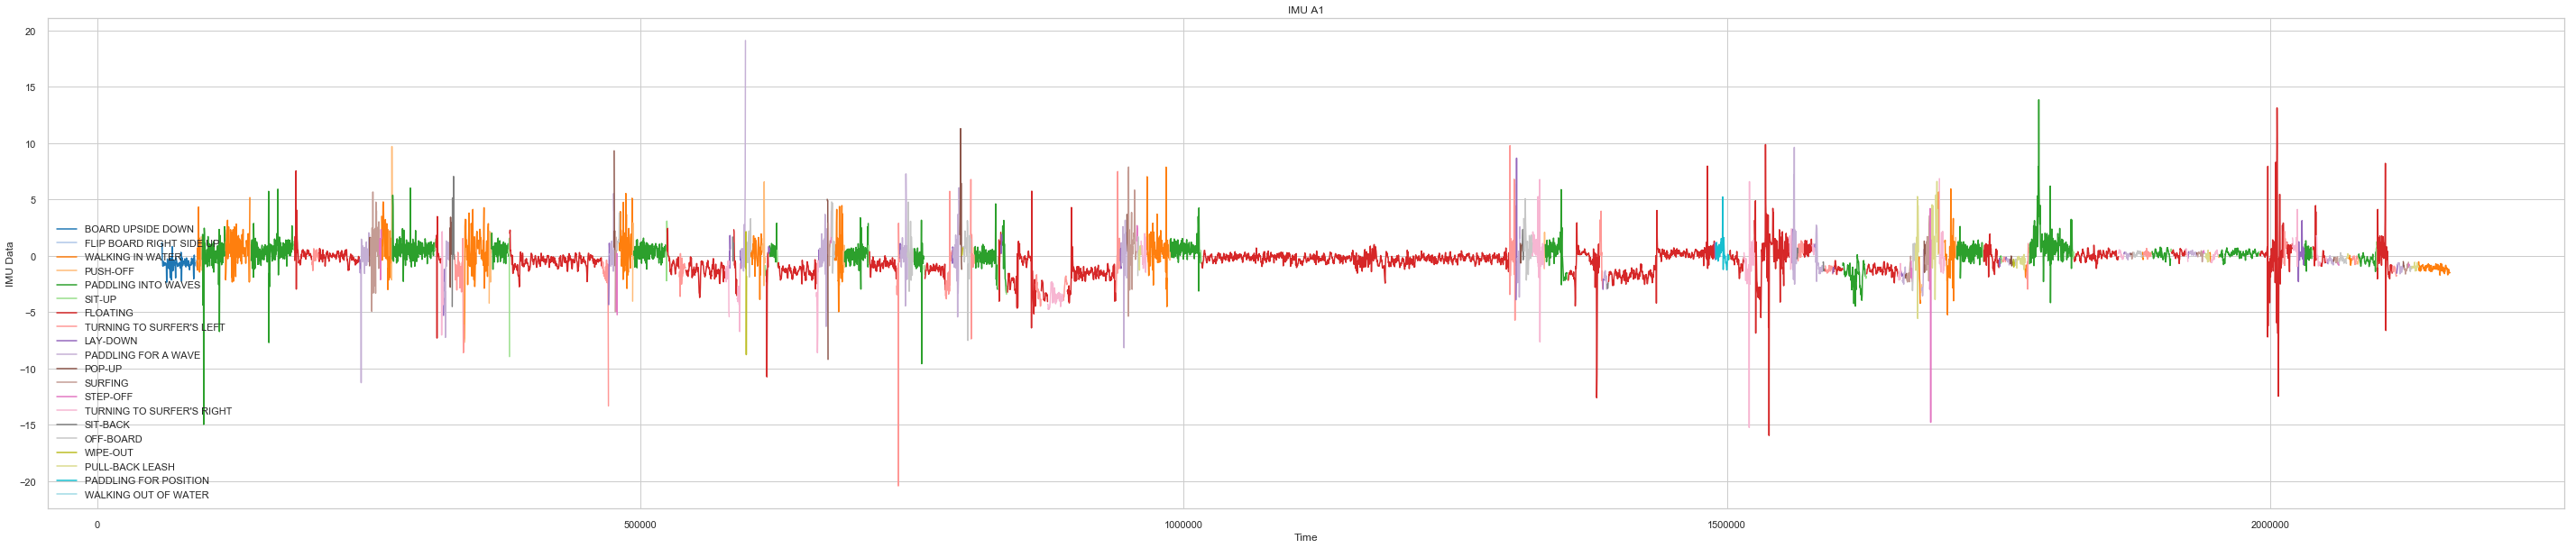

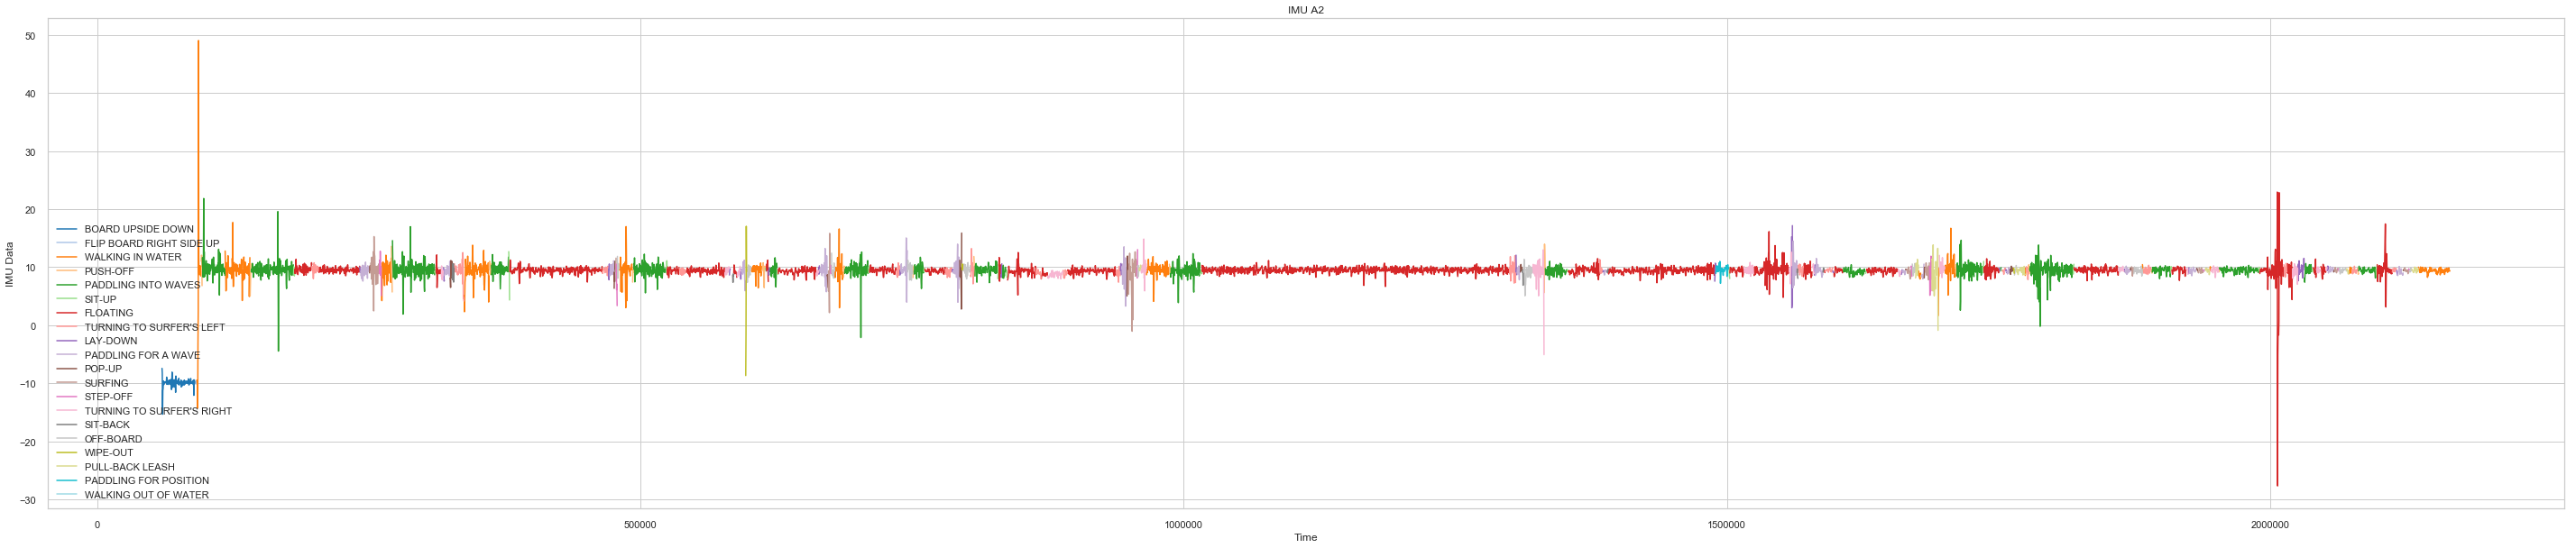

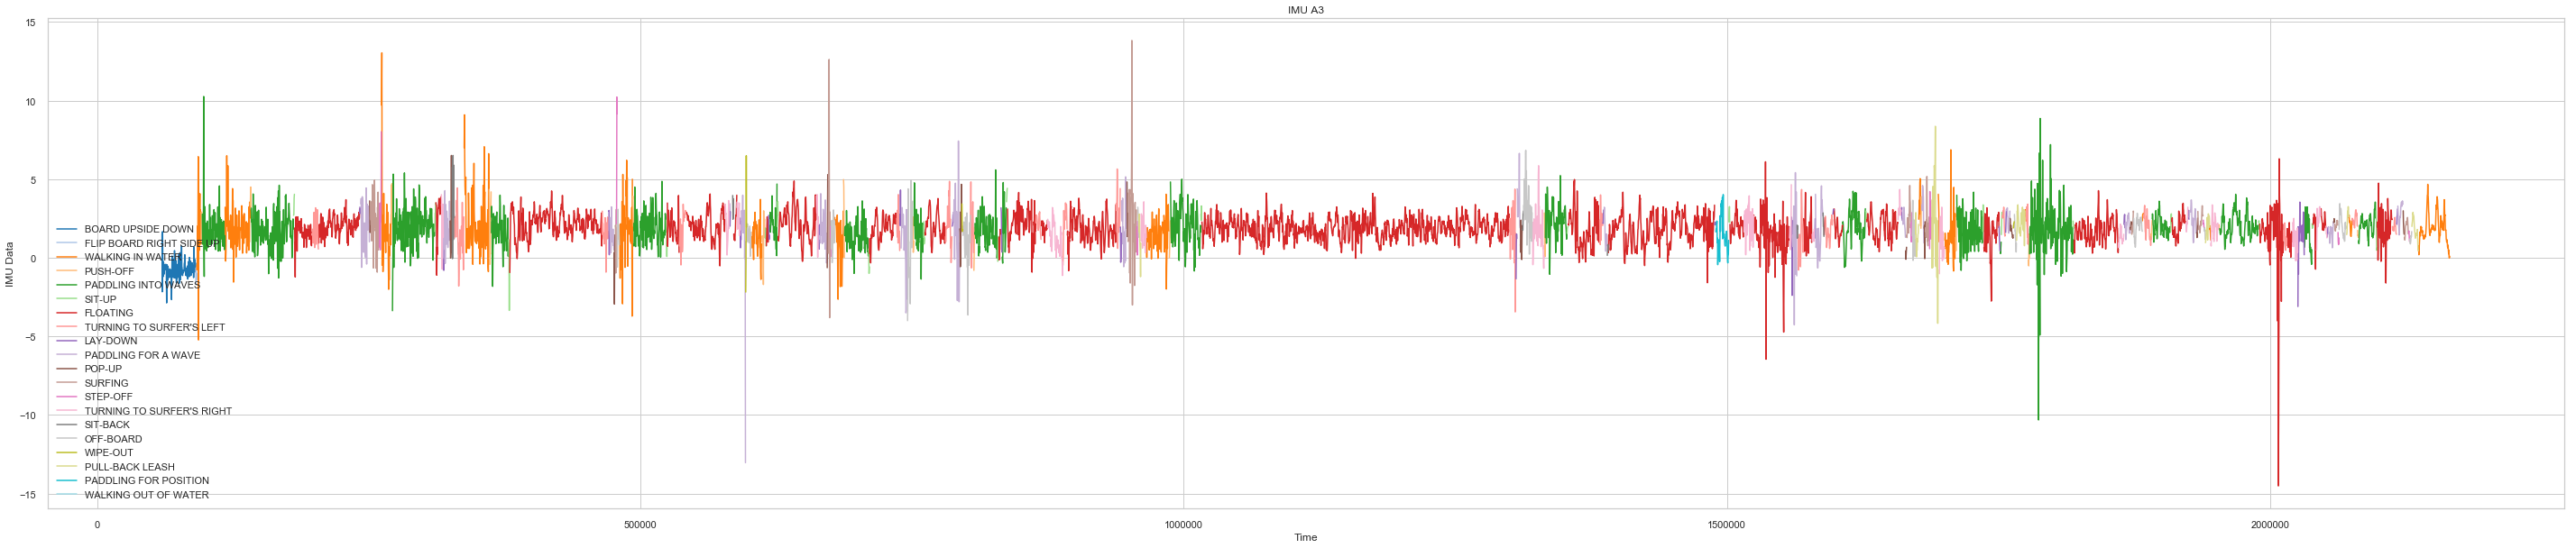

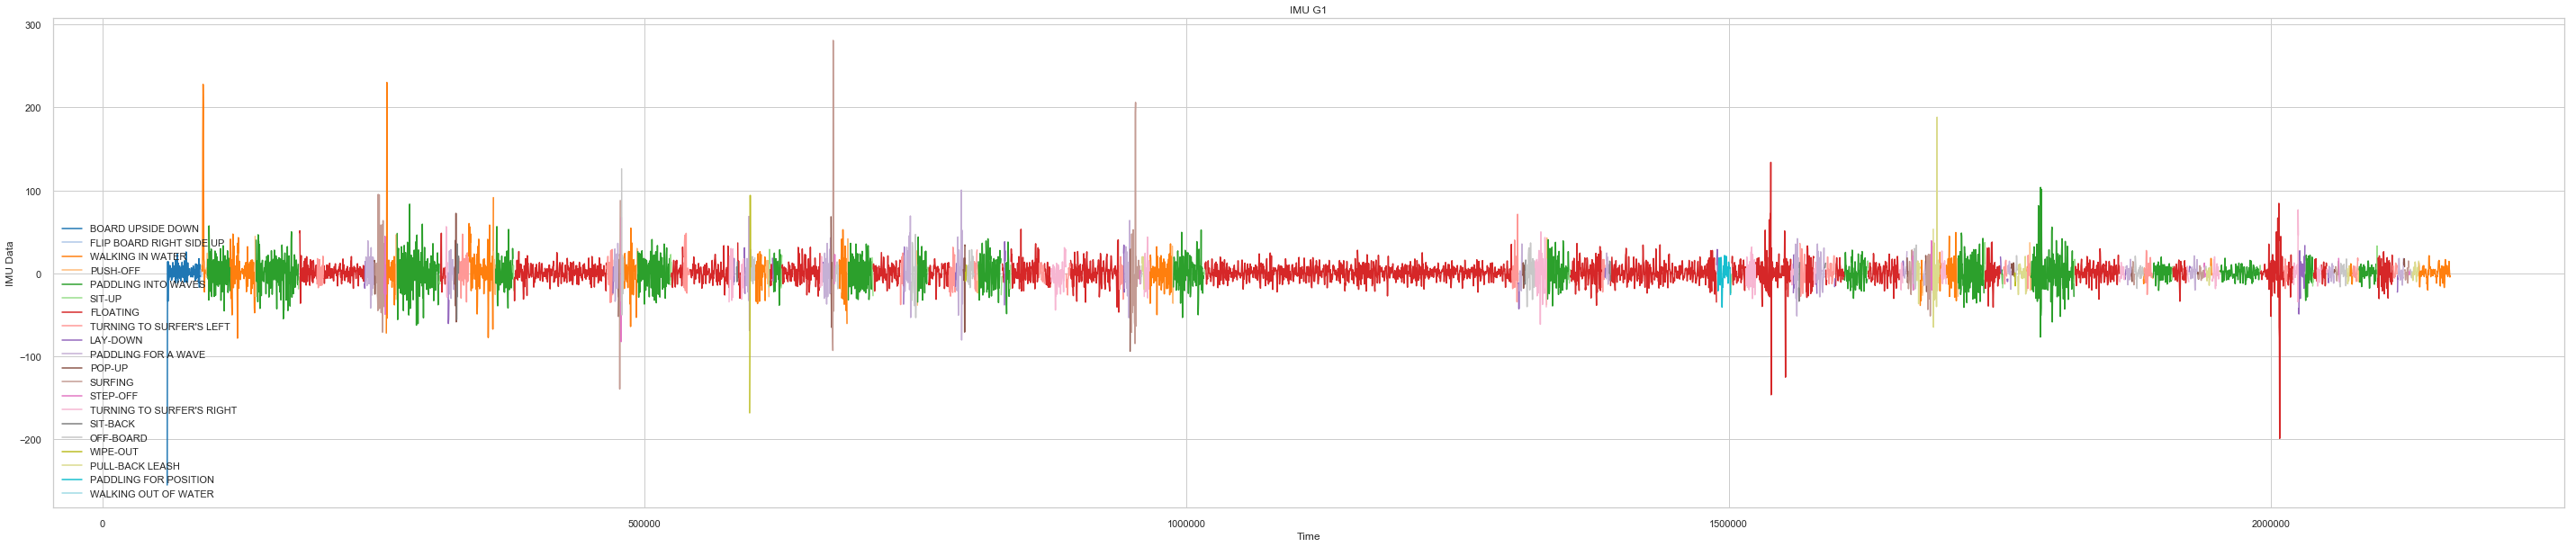

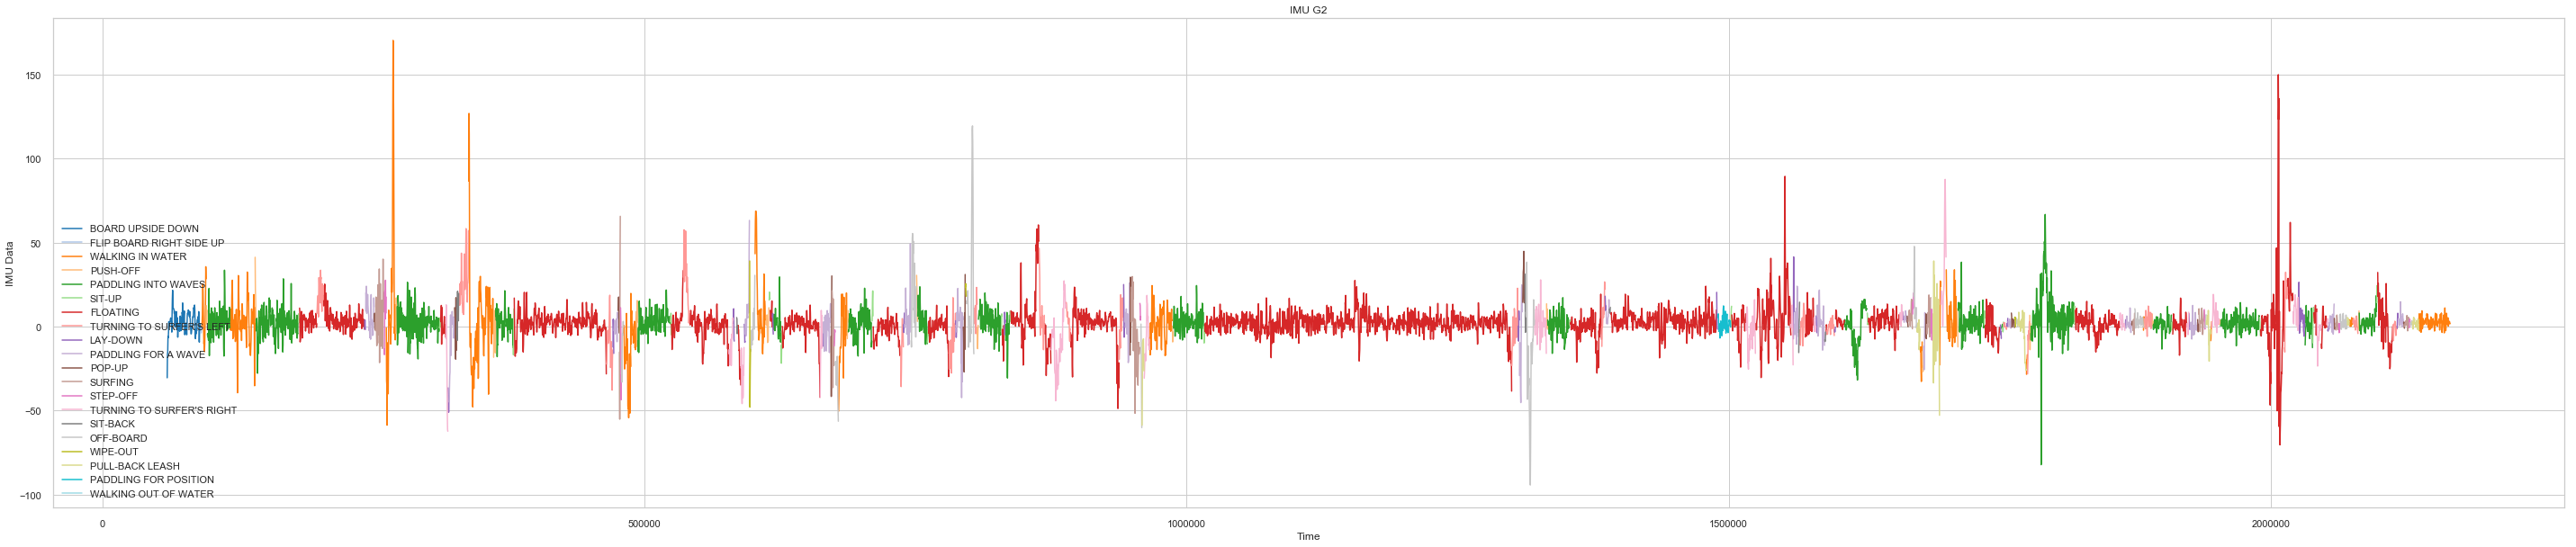

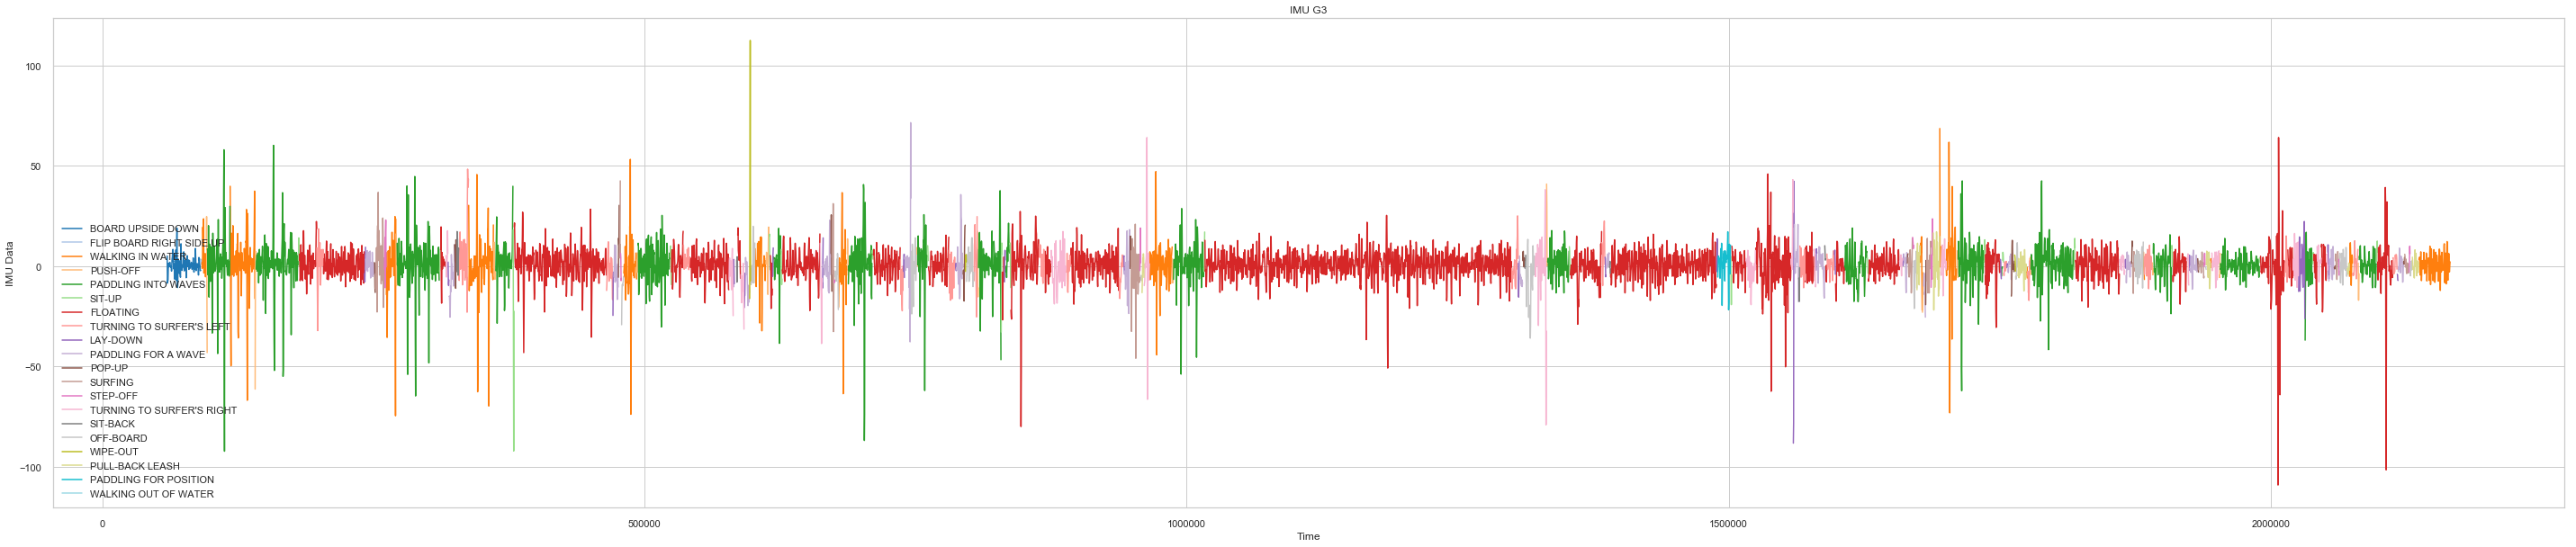

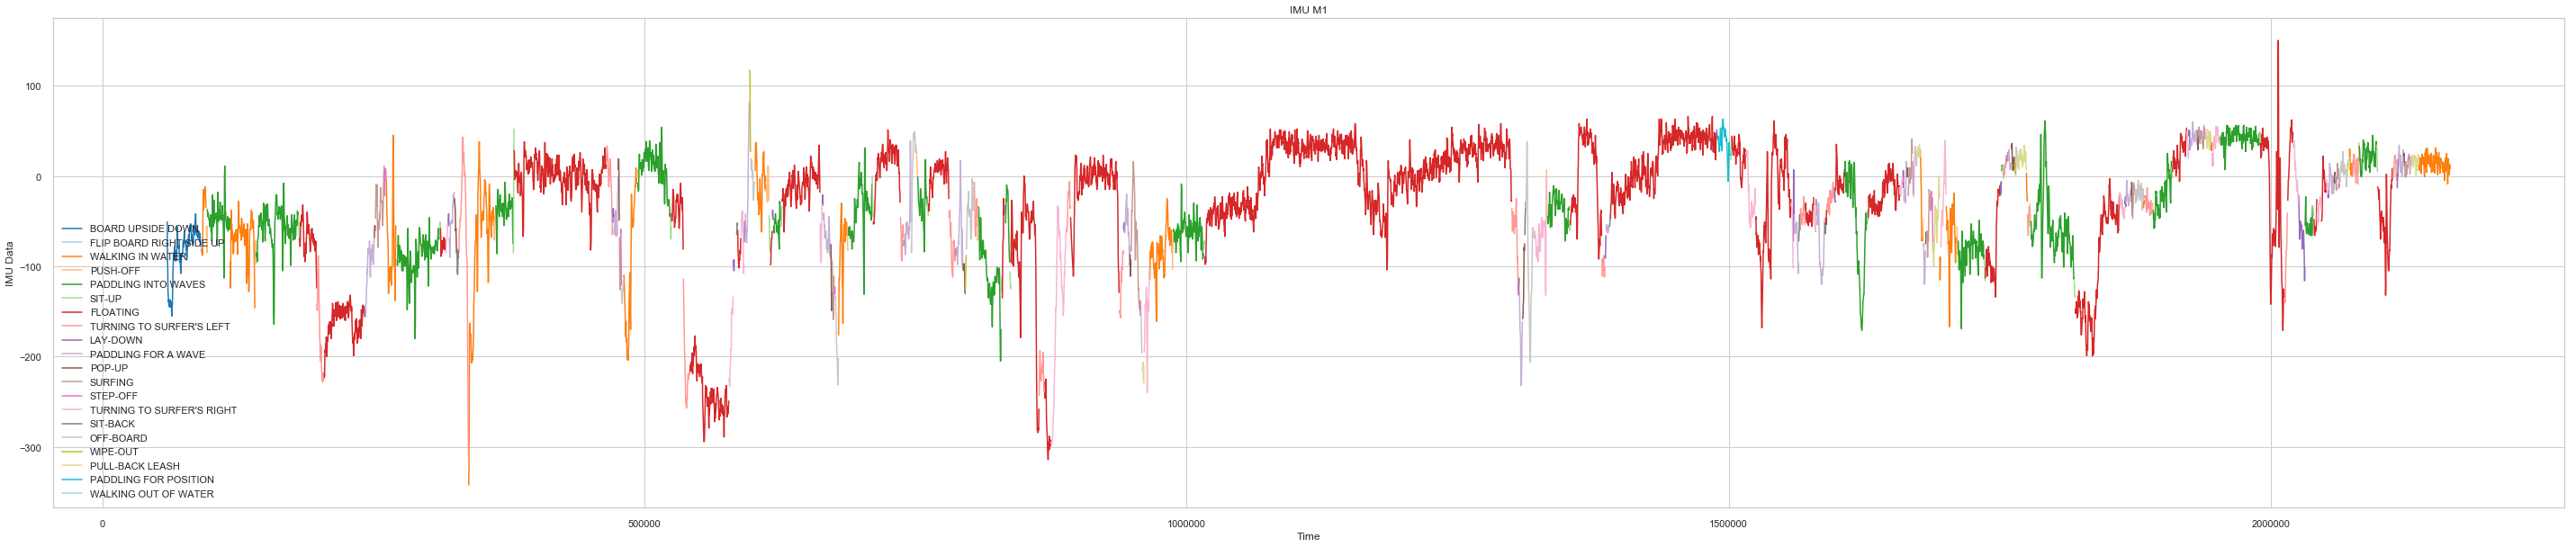

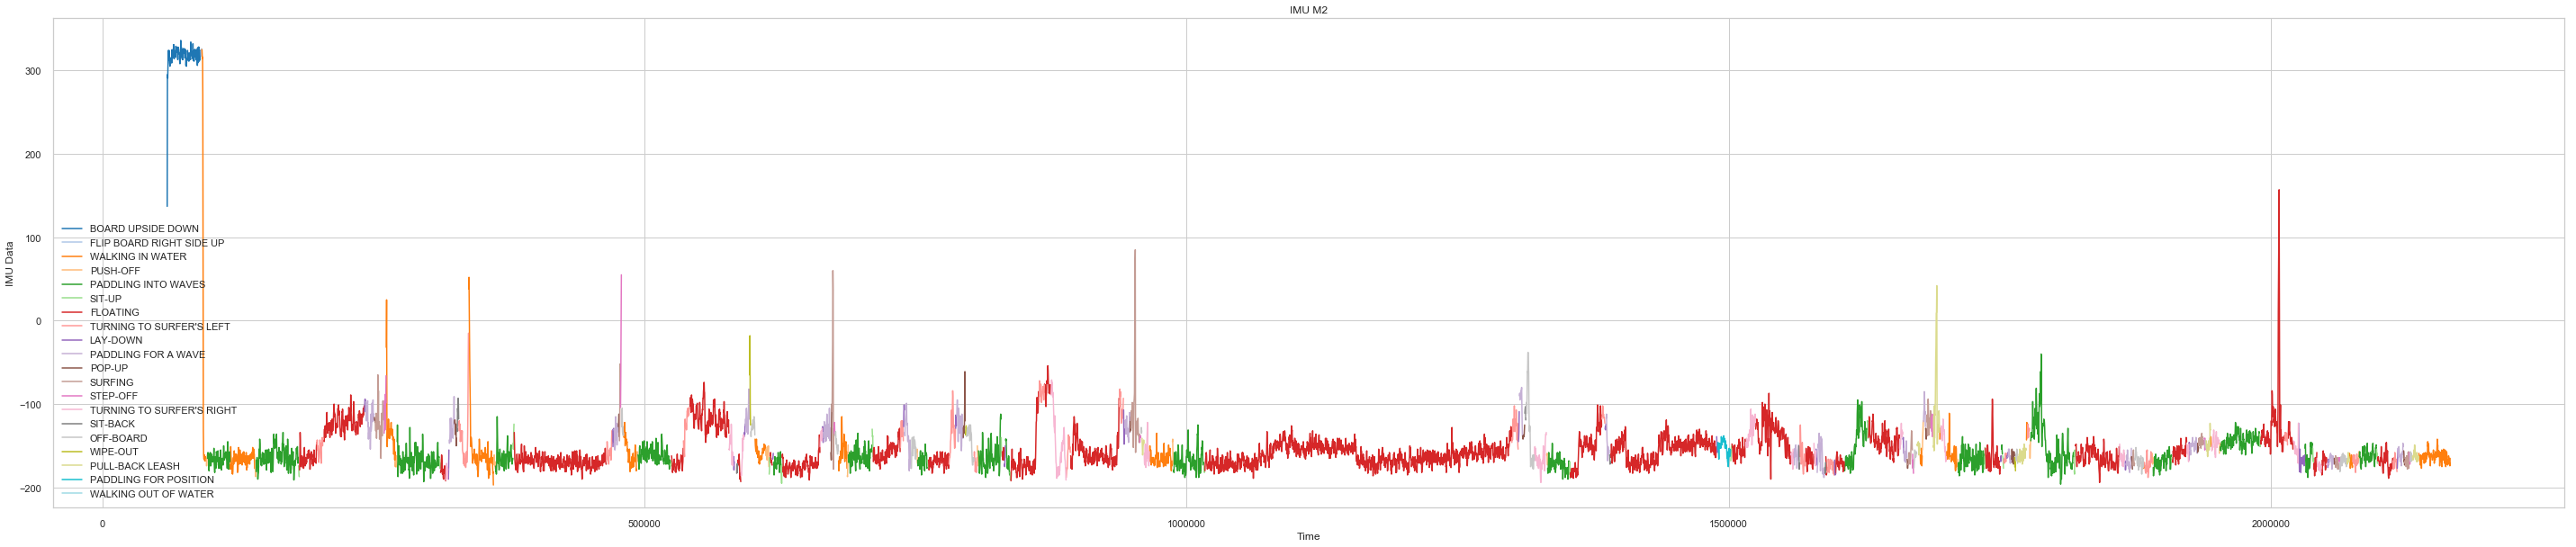

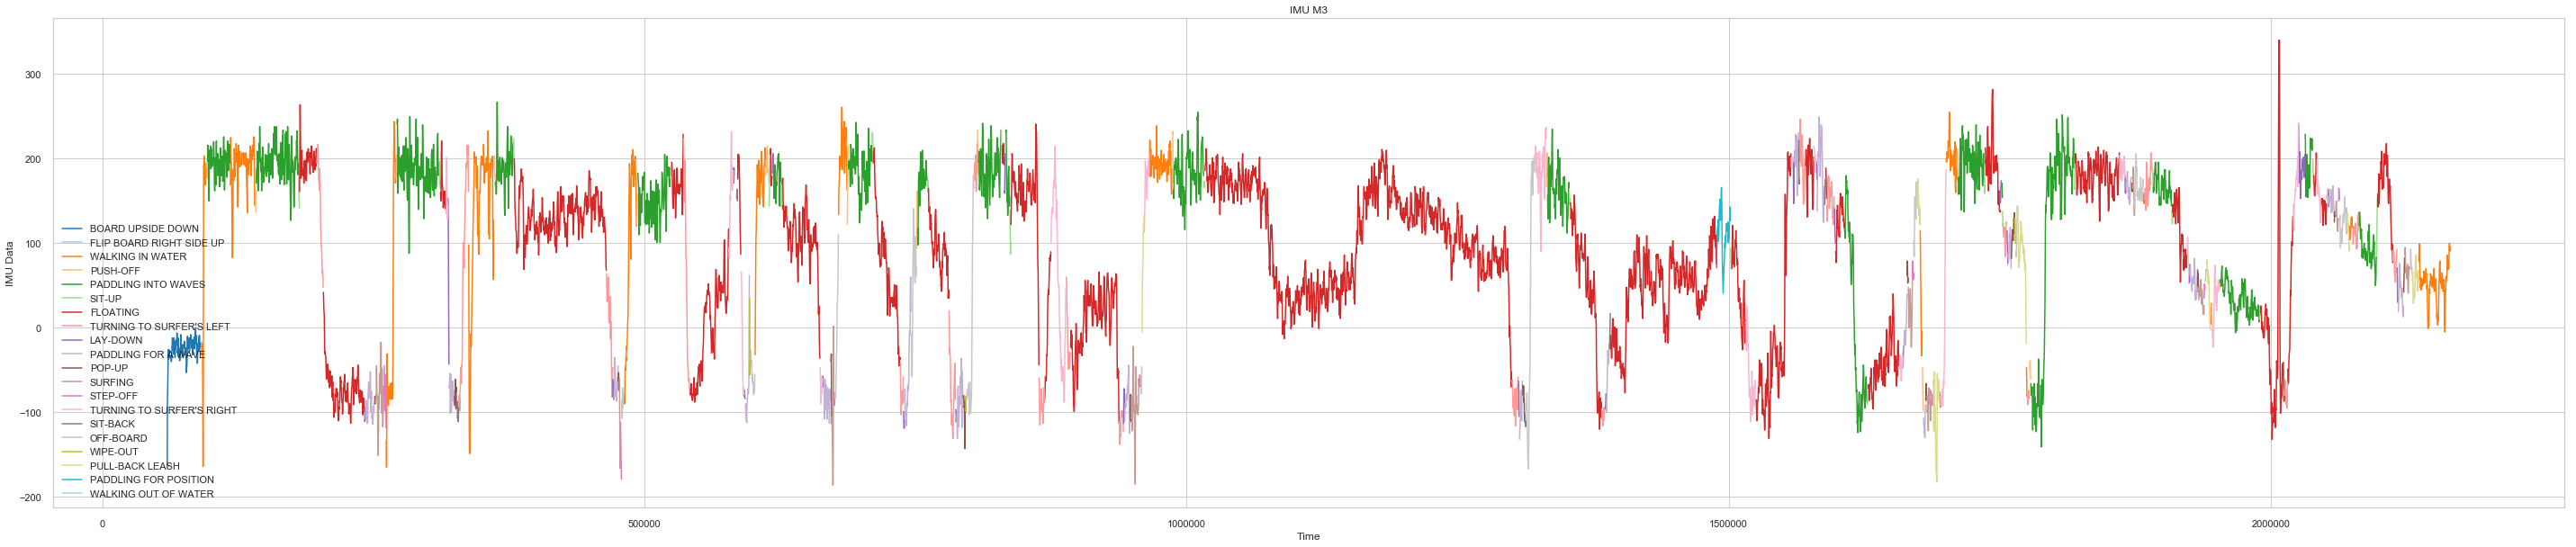

Done


In [349]:
#For plotting, just comment out the "concatenation" lines. 

#Need to clear kernel and then only run all above so that it plots on axes directly below, rather than on another plot
print("Creating Plots...")
createPlot(df_converted,'IMU A1')
createPlot(df_converted,'IMU A2')
createPlot(df_converted,'IMU A3')
createPlot(df_converted,'IMU G1')
createPlot(df_converted,'IMU G2')
createPlot(df_converted,'IMU G3')
createPlot(df_converted,'IMU M1')
createPlot(df_converted,'IMU M2')
createPlot(df_converted,'IMU M3')

print("Done")


## Butterworth Bandpass Filter

Plotting:


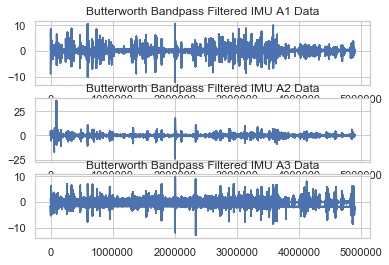

The plot for IMUA2 might be problematic because it truncates the sync step that happens in the beginning of the signal...


In [50]:
## Apply a Filter to the signals to reduce noise:
## Butter Filters for Bandpass:
%matplotlib inline
from scipy import signal
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_lfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



##Butter Filters for Highpass:
def butter_highpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a

def butter_highpass_lfilter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



##Butter Filters for Lowpass:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_lfilter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y




# Define the sample rate and the Low and High Cutoff frequencies
#fs = 30
fs = 5
lowcut = 0.0333
highcut = 1.5


#Get each IMU column from the dataframe: 
#array = df_converted.values

time_array = df_converted['TimeDelta'].values
imua1_array = df_converted['IMU A1'].values
imua2_array = df_converted['IMU A2'].values
imua3_array = df_converted['IMU A3'].values

imug1_array = df_converted['IMU G1'].values
imug2_array = df_converted['IMU G2'].values
imug3_array = df_converted['IMU G3'].values

imum1_array = df_converted['IMU M1'].values
imum2_array = df_converted['IMU M2'].values
imum3_array = df_converted['IMU M3'].values


##Graphing the bandpass filters:
#A bandpass filter is both a highpass and a lowpass filter combined.
butter_lfilter_a1 = butter_bandpass_lfilter(imua1_array, lowcut, highcut, fs, order=5)
butter_lfilter_a2 = butter_bandpass_lfilter(imua2_array, lowcut, highcut, fs, order=5)
butter_lfilter_a3 = butter_bandpass_lfilter(imua3_array, lowcut, highcut, fs, order=5)

butter_lfilter_g1 = butter_bandpass_lfilter(imug1_array, lowcut, highcut, fs, order=5)
butter_lfilter_g2 = butter_bandpass_lfilter(imug2_array, lowcut, highcut, fs, order=5)
butter_lfilter_g3 = butter_bandpass_lfilter(imug3_array, lowcut, highcut, fs, order=5)


#butter_filtfilt = butter_bandpass_filtfilt(dacc_array1, lowcut, highcut, fs, order=5)



#Can change num_elems to 1000 for example if you only want to graph the first 1000 elems:
num_elems = len(time_array)

print("Plotting:")
plt.figure(1)
plt.subplot(311)
plt.plot(time_array[:num_elems], butter_lfilter_a1[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A1 Data")

plt.subplot(312)
plt.plot(time_array[:num_elems], butter_lfilter_a2[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A2 Data")

plt.subplot(313)
plt.plot(time_array[:num_elems], butter_lfilter_a3[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A3 Data")

#Save as file
file_name = "butter_worth_graphs"
pdf_string = '.jpg'
file_name += pdf_string
plt.savefig(file_name)

#Show in line
plt.show()

#print("The plot for IMUA2 might be problematic because it truncates the sync step that happens in the beginning of the signal...")

In [59]:
##Include the Butterworth (acc, gyro) filtered data as an input feature: 
df_converted['BFilter_IMU_A1'] = pd.Series(imua1_array, index=df_converted.index)
df_converted['BFilter_IMU_A2'] = pd.Series(imua2_array, index=df_converted.index)
df_converted['BFilter_IMU_A3'] = pd.Series(imua3_array, index=df_converted.index)

df_converted['BFilter_IMU_G1'] = pd.Series(imug1_array, index=df_converted.index)
df_converted['BFilter_IMU_G2'] = pd.Series(imug2_array, index=df_converted.index)
df_converted['BFilter_IMU_G3'] = pd.Series(imug3_array, index=df_converted.index)

#list(df_converted)
#df_converted.head(1)

new_col_order = ['Time',
 'IMU A1',
 'IMU A2',
 'IMU A3',
 'IMU G1',
 'IMU G2',
 'IMU G3',
 'IMU M1',
 'IMU M2',
 'IMU M3',
 'BFilter_IMU_A1',
 'BFilter_IMU_A2',
 'BFilter_IMU_A3',
 'BFilter_IMU_G1',
 'BFilter_IMU_G2',
 'BFilter_IMU_G3',
 'TimeDelta',
 'BOARD UPSIDE DOWN',
 'WALKING IN WATER',
 'PUSH-OFF',
 'PADDLING INTO WAVES',
 'SIT-UP',
 'FLOATING',
 "TURNING TO SURFER'S LEFT",
 'LAY-DOWN',
 'PADDLING FOR A WAVE',
 'POP-UP',
 'SURFING',
 'STEP-OFF',
 "TURNING TO SURFER'S RIGHT",
 'SIT-BACK',
 'OFF-BOARD',
 'WIPE-OUT',
 'PULL-BACK LEASH',
 'PADDLING FOR POSITION']

df_converted = df_converted[new_col_order]
list(df_converted)



['Time',
 'IMU A1',
 'IMU A2',
 'IMU A3',
 'IMU G1',
 'IMU G2',
 'IMU G3',
 'IMU M1',
 'IMU M2',
 'IMU M3',
 'BFilter_IMU_A1',
 'BFilter_IMU_A2',
 'BFilter_IMU_A3',
 'BFilter_IMU_G1',
 'BFilter_IMU_G2',
 'BFilter_IMU_G3',
 'TimeDelta',
 'BOARD UPSIDE DOWN',
 'WALKING IN WATER',
 'PUSH-OFF',
 'PADDLING INTO WAVES',
 'SIT-UP',
 'FLOATING',
 "TURNING TO SURFER'S LEFT",
 'LAY-DOWN',
 'PADDLING FOR A WAVE',
 'POP-UP',
 'SURFING',
 'STEP-OFF',
 "TURNING TO SURFER'S RIGHT",
 'SIT-BACK',
 'OFF-BOARD',
 'WIPE-OUT',
 'PULL-BACK LEASH',
 'PADDLING FOR POSITION']

### Filtering data with a butterworth filter, then plotting in 2D: 

In [61]:
## 2D scatterplots: 
%matplotlib notebook
import matplotlib.pyplot as plt

# Create data
x = imua1_array
y = imug1_array
area = np.pi*3

colors = []
no_misc = []
for i in range(0,len(data_y)):
    #if data_y[i] == 'MISC': 
        #colors.append("yellow")
    if data_y[i] == 'PADDLING':
         colors.append("green")
    if data_y[i] == 'SURFING': 
        colors.append("blue")
    if data_y[i] == 'FLOATING': 
        colors.append("red")

# Plot
print("Plotting...")
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
#plt.title('')
plt.xlabel('IMU A1')
plt.ylabel('IMU G3')
plt.show()
print("Done")

NameError: name 'data_y' is not defined

## Update dataframe with the filtered values, then do another labelled plot of all IMU values: 

## Binary Logistic Regression Model on Raw data values: 

In [76]:
## Make sure that the df_converted that gets copied does not get changed by the filtering methods being tested.
dataset = df_converted.copy()

print(dataset.head(1))

                                         Time    IMU A1    IMU A2   IMU A3  \
ride_id UTC                                                                  
15692   2018-11-09 19:16:03.789  1.414743e+09 -9.436513  0.918768  2.10551   

                                   IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  9.146341 -15.121951 -10.487805  -309.0   

                                 IMU M2  IMU M3  BFilter_IMU_A1  \
ride_id UTC                                                       
15692   2018-11-09 19:16:03.789   209.0    39.0       -9.436513   

                                 BFilter_IMU_A2  BFilter_IMU_A3  \
ride_id UTC                                                       
15692   2018-11-09 19:16:03.789        0.918768         2.10551   

                                 BFilter_IMU_G1  BFilter_IMU_G2  \
ride_id UTC                                                       
1

In [77]:
print(dataset.columns)

Index(['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3',
       'IMU M1', 'IMU M2', 'IMU M3', 'BFilter_IMU_A1', 'BFilter_IMU_A2',
       'BFilter_IMU_A3', 'BFilter_IMU_G1', 'BFilter_IMU_G2', 'BFilter_IMU_G3',
       'TimeDelta', 'BOARD UPSIDE DOWN', 'WALKING IN WATER', 'PUSH-OFF',
       'PADDLING INTO WAVES', 'SIT-UP', 'FLOATING', 'TURNING TO SURFER'S LEFT',
       'LAY-DOWN', 'PADDLING FOR A WAVE', 'POP-UP', 'SURFING', 'STEP-OFF',
       'TURNING TO SURFER'S RIGHT', 'SIT-BACK', 'OFF-BOARD', 'WIPE-OUT',
       'PULL-BACK LEASH', 'PADDLING FOR POSITION'],
      dtype='object')


In [163]:
#Link which explains below: 
#https://stackoverflow.com/questions/37512079/python-pandas-why-does-df-iloc-1-values-for-my-training-data-select-till

#Not using filtered inputs: 
#X = dataset.iloc[:, :10].values  #selects everything until the last column listed (in this case, the 0-15 columns get taken)

#Using filtered inputs: 
X = dataset.iloc[:, :17].values  #selects everything until the last column listed (in this case, the 0-15 columns get taken)

#TURNING TO SURFER\'S RIGHT
y = dataset.loc[:,'FLOATING'].values   #selects the column specified (ex: 'FLOATING')
print("X.shape:", X.shape)
print("y.shape:", y.shape)


#What is the column heading of the y column given? 
print(dataset.iloc[0][-1])

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("first few y_train values:", y_train[0:20])
print("first few y_test values:", y_test[0:20])

#The y-axis is currently set to the 19th frame ("FLOATING").

#X_train_res = X_train
#y_train_res = y_train

X.shape: (86580, 17)
y.shape: (86580,)
0.0
x_train shape: (77922, 17)
y_train shape: (77922,)
x_test shape: (8658, 17)
y_test shape: (8658,)
first few y_train values: [0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
first few y_test values: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0]


In [164]:
#May need to use SMOTE technique to balance the data more equally (so majority class i.e. 0 doesn't dominate).
#SMOTE explanation: http://rikunert.com/SMOTE_explained
#Example code: https://beckernick.github.io/oversampling-modeling/

from imblearn.over_sampling import SMOTE, ADASYN 

#sm = SMOTE(random_state=12, ratio=1.0)
#X_train_res, y_train_res = sm.fit_sample(X_train, y_train)  #oversample on only the training data, after splitting the data initially into training and testing sets
X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)

print(len(X_train_res))
print(len(y_train_res))

y_count_0 = 0
y_count_1 = 0
for y in y_train_res: 
    if y==1: 
        y_count_1 += 1
    else: 
        y_count_0 += 1
        
print("Number of 1's:", y_count_1)
print("Number of 0's:", y_count_0)


#Now using ADASYN instead of SMOTE
#X_train_res, y_train_res = ADASYN().fit_resample(X_train, y_train)


135464
135464
Number of 1's: 67732
Number of 0's: 67732


In [165]:
# Fit into Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs', class_weight='balanced')
classifier.fit(X=X_train_res, y=y_train_res)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [166]:
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix

# Predicting the Test set results
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

#print("Printing every y in y_test:")
#for y in y_test:
#    print(y)
#print(y_test)

#print(y_pred[0:500]) #just checking to make sure that it's actually guessing (not just always 0)

[[5974 1583]
 [  78 1023]]


<IPython.core.display.Javascript object>


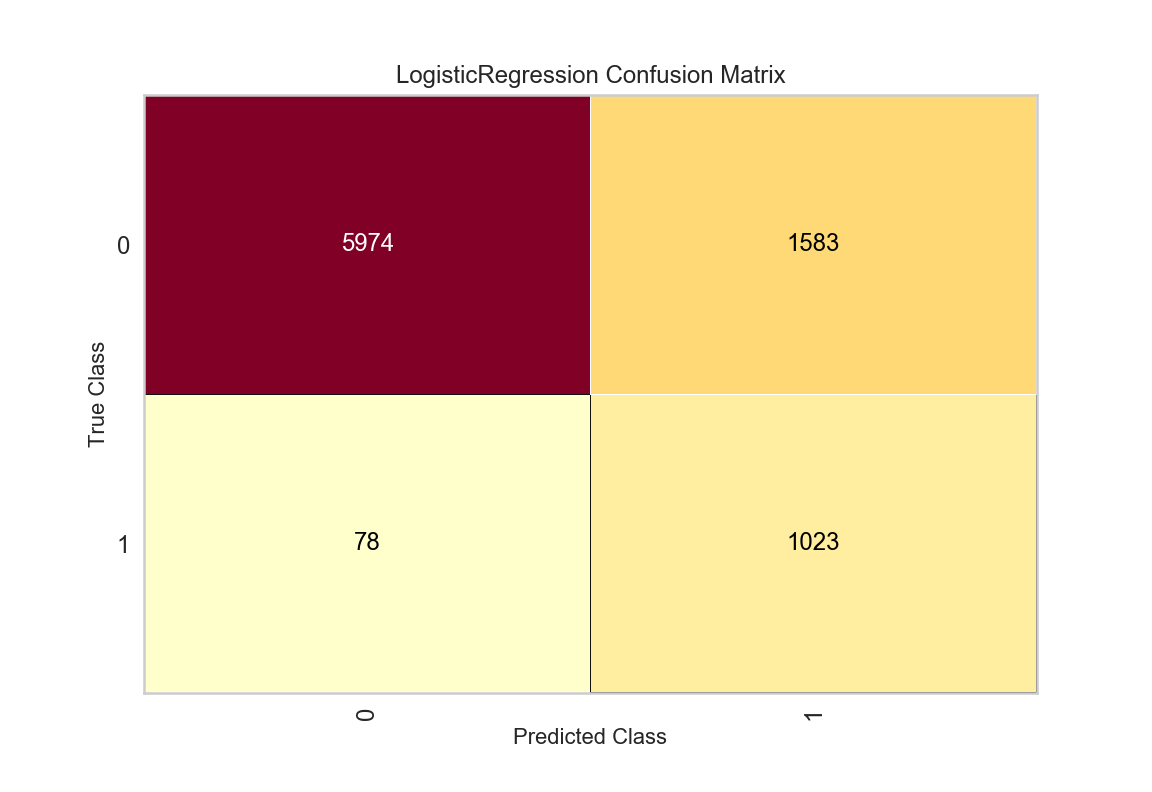

In [167]:
#Make a prettier looking confusion matrix using yellowbrick visualizers: 

cm = ConfusionMatrix(classifier, classes=[0,1])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_res, y_train_res)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.poof()


In [146]:
# 10-cross Fold
from sklearn.model_selection import cross_val_score
score = cross_val_score(estimator = classifier, X = X_train_res, y = y_train_res, cv = 10)
#score = cross_val_score(estimator = classifier, X = X, y = y, cv = 10)
print(cross_val_score)
print(score)

<function cross_val_score at 0x1a193fa400>
[0.85769117 0.8591674  0.86246863 0.8581131  0.86283774 0.85338845
 0.85929426 0.86298538 0.85634136 0.86047542]


In [162]:
avg = 0.0
num = 0.0
for s in score: 
    avg += s
    num += 1.0
    
avg = avg/num
print(avg)

0.8592762902912016


In [70]:
print(y.shape)

(86580,)


## Training Multiple Binary Logistic Regression Models

In [71]:
#Create one for surfing, paddling, floating, etc. all trained on same training data

#For each point in the "test" category, determine the probability that it is floating/paddling/surfing

#Choose the model that gives the highest probability 



## Setting up dataframe for Single Multinomial Logistic Regression Model
### Footage sync code: (Single-Column, Multi-Class)

In [359]:
#Copy the converted dataset, keep the features, and create only one column that contains labels. 

print("Creating multiclass dataframe...")

#Can also add "UTC Time" and "Time Delta" columns if needed later. 
multiclass_df = df_converted[['IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3']].copy()
parse_df = df_converted.copy()

print(multiclass_df.head(10))
      
    
#Parse the columns of the original dataframe to extract labels into a single column for the new multiclass df. 
def parse_func(x):
    l=[]
    val = 1
    for col in parse_df:
        if x[col] == val:
            l.append(col)

    return pd.Series(l)

parse_df = parse_df.apply(parse_func, axis=1)
print(parse_df.head(100))


#Drop the 2nd column of parse_df (which has all NaN values)
cols = [1]
parse_df.drop(parse_df.columns[cols],axis=1,inplace=True)
parse_df.columns=['complex_label']
#print(parse_df.head(100))


#Concatenate the parse column with the multiclass dataframe. 
multiclass_df = pd.concat([multiclass_df, parse_df], axis=1, sort=False)
#print(multiclass_df.head(100))

#Drop the NaN rows from the beginning/end of the df.
print("Shape before dropping NA:", multiclass_df.shape)
multiclass_df = multiclass_df.dropna()
print("Shape after dropping NA:", multiclass_df.shape)
print(multiclass_df.head(10))


complex_multiclass_df = multiclass_df.copy()
print("\n Done creating complex multiclass df.")


Creating multiclass dataframe...
                                    IMU A1    IMU A2    IMU A3     IMU G1  \
ride_id UTC                                                                 
15692   2018-11-09 19:16:03.789  -9.436513  0.918768  2.105510   9.146341   
        2018-11-09 19:16:04.053  -9.819333  1.703549  1.186742   4.146341   
        2018-11-09 19:16:04.284  -9.455654  1.760972  1.531280   8.414634   
        2018-11-09 19:16:04.548  -8.058361  3.923905 -1.990664  23.414634   
        2018-11-09 19:16:04.812 -10.221294  5.857146 -0.612512 -51.341463   
        2018-11-09 19:16:05.043  -8.709155  2.852009 -1.952382 -43.292683   
        2018-11-09 19:16:05.307  -9.072834  6.546222 -4.191879 -28.536585   
        2018-11-09 19:16:05.571  -6.948183  6.182543 -2.507471   7.317073   
        2018-11-09 19:16:05.802   0.401961  9.761910 -8.556027   9.512195   
        2018-11-09 19:16:06.066  -0.669935  5.416903 -2.526612 -13.902439   

                                    IMU G2

### Create Simplified Multiclass Labels

In [360]:
#Create simple multiclass df: (Surfing, Floating, Paddling, Misc.)

simple_multiclass_df = multiclass_df.copy()

simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('SURFING|PADDLING|FLOATING')==False, 'complex_label'] = 'MISC'
simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('PADDLING'), 'complex_label'] = 'PADDLING'

##simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('POP-UP'), 'complex_label'] = 'SURFING'
##simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('TURNING'), 'complex_label'] = 'FLOATING'


column_names = list(simple_multiclass_df)
column_names = column_names[:-1]
column_names.append("simple_label")

print(column_names)
simple_multiclass_df.columns=column_names

print(simple_multiclass_df.head(5))

simple_misc_multiclass_df = simple_multiclass_df.copy()

##Check to see that labels exist: 
##To exclude "Misc" from data: 
simple_multiclass_df = simple_multiclass_df[simple_multiclass_df['simple_label'].str.match('FLOATING|PADDLING|SURFING')]

##To include "Misc" from data:
#simple_multiclass_df = simple_multiclass_df[simple_multiclass_df['simple_label'].str.match('FLOATING|PADDLING|SURFING|MISC')]

print(simple_multiclass_df.head(5))


['IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'simple_label']
                                   IMU A1     IMU A2    IMU A3      IMU G1  \
ride_id UTC                                                                  
15692   2018-11-09 19:17:03.915  1.148460  -7.426708  1.492998 -255.853659   
        2018-11-09 19:17:04.146 -0.267974  -8.268912 -2.162933  -48.902439   
        2018-11-09 19:17:04.410 -0.555089 -15.331941  1.665267   13.902439   
        2018-11-09 19:17:04.674 -0.918768 -11.235767 -0.497666  -34.024390   
        2018-11-09 19:17:04.905 -0.746499 -10.910370 -1.205883   -3.658537   

                                    IMU G2    IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                                    
15692   2018-11-09 19:17:03.915 -30.487805  5.000000   -51.0   137.0  -165.0   
        2018-11-09 19:17:04.146 -16.585366 -8.536585   -87.0   295.0   -85.0   
        2018-11-09 19:17:0

## Visualizing raw multinomial data: 

### Need to run the %matplotlib notebook cells 2-3x in a row to get proper display:

['PADDLING' 'PADDLING' 'PADDLING' ... 'SURFING' 'SURFING' 'SURFING']
6688


<IPython.core.display.Javascript object>


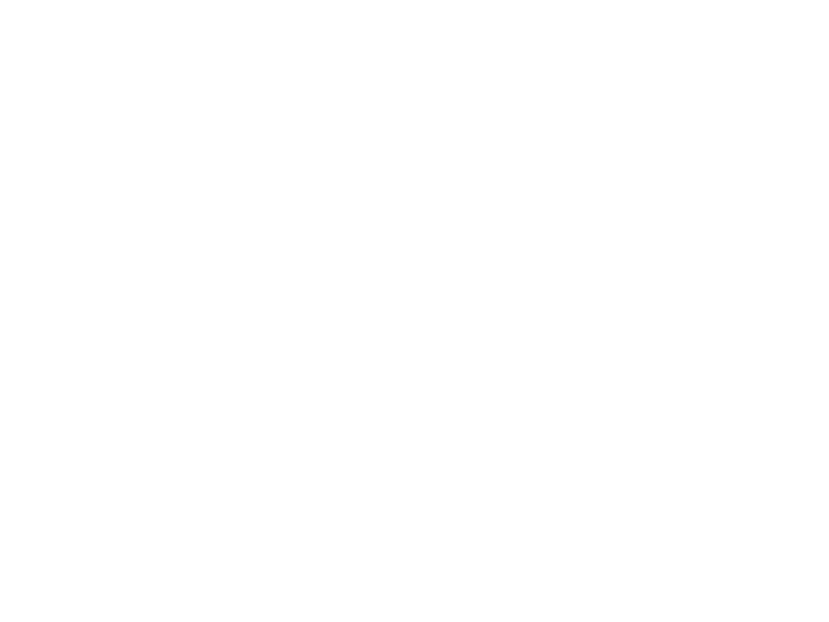

<IPython.core.display.Javascript object>


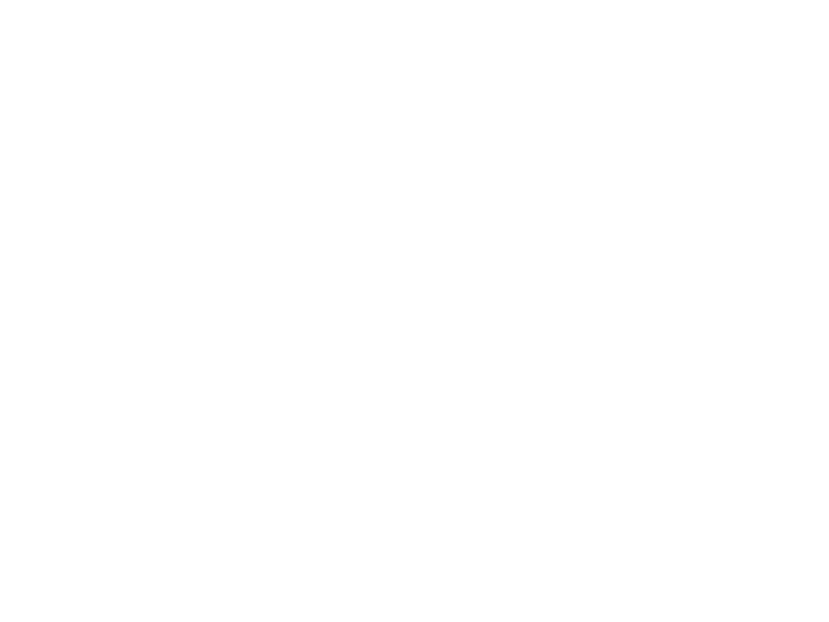

In [125]:
##Visualizing the data in 3d. 

%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

data = simple_multiclass_df.copy()

data_y = data.loc[:,'simple_label'].values
#y = y.tolist()
print(data_y)

n = len(data_y)
print(n)

colors = []
no_misc = []
for i in range(0,n):
    if data_y[i] == 'MISC': 
        colors.append("yellow")
    if data_y[i] == 'PADDLING':
         colors.append("green")
    if data_y[i] == 'SURFING': 
        colors.append("blue")
    if data_y[i] == 'FLOATING': 
        colors.append("red")
        
#print(colors)



td_plot = plt.figure(figsize=[6.4, 4.8]).gca(projection='3d')
td_plot.scatter(data['IMU G1'], data['IMU G2'], data['IMU G3'], c=colors)
#td_plot.scatter(data['IMU G1'], data['IMU G2'], data['IMU G3'])
td_plot.set_xlabel('IMU G1')
td_plot.set_ylabel('IMU G2')
td_plot.set_zlabel('IMU G3')

scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c="red", marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c="green", marker = 'o')
scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c="blue", marker = 'o')
scatter4_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c="yellow", marker = 'o')

td_plot.legend([scatter1_proxy, scatter2_proxy, scatter3_proxy, scatter4_proxy], ["FLOATING", "PADDLING", "SURFING", "MISC"], numpoints = 1)

#td_plot.legend()

plt.show()

Plotting...


<IPython.core.display.Javascript object>


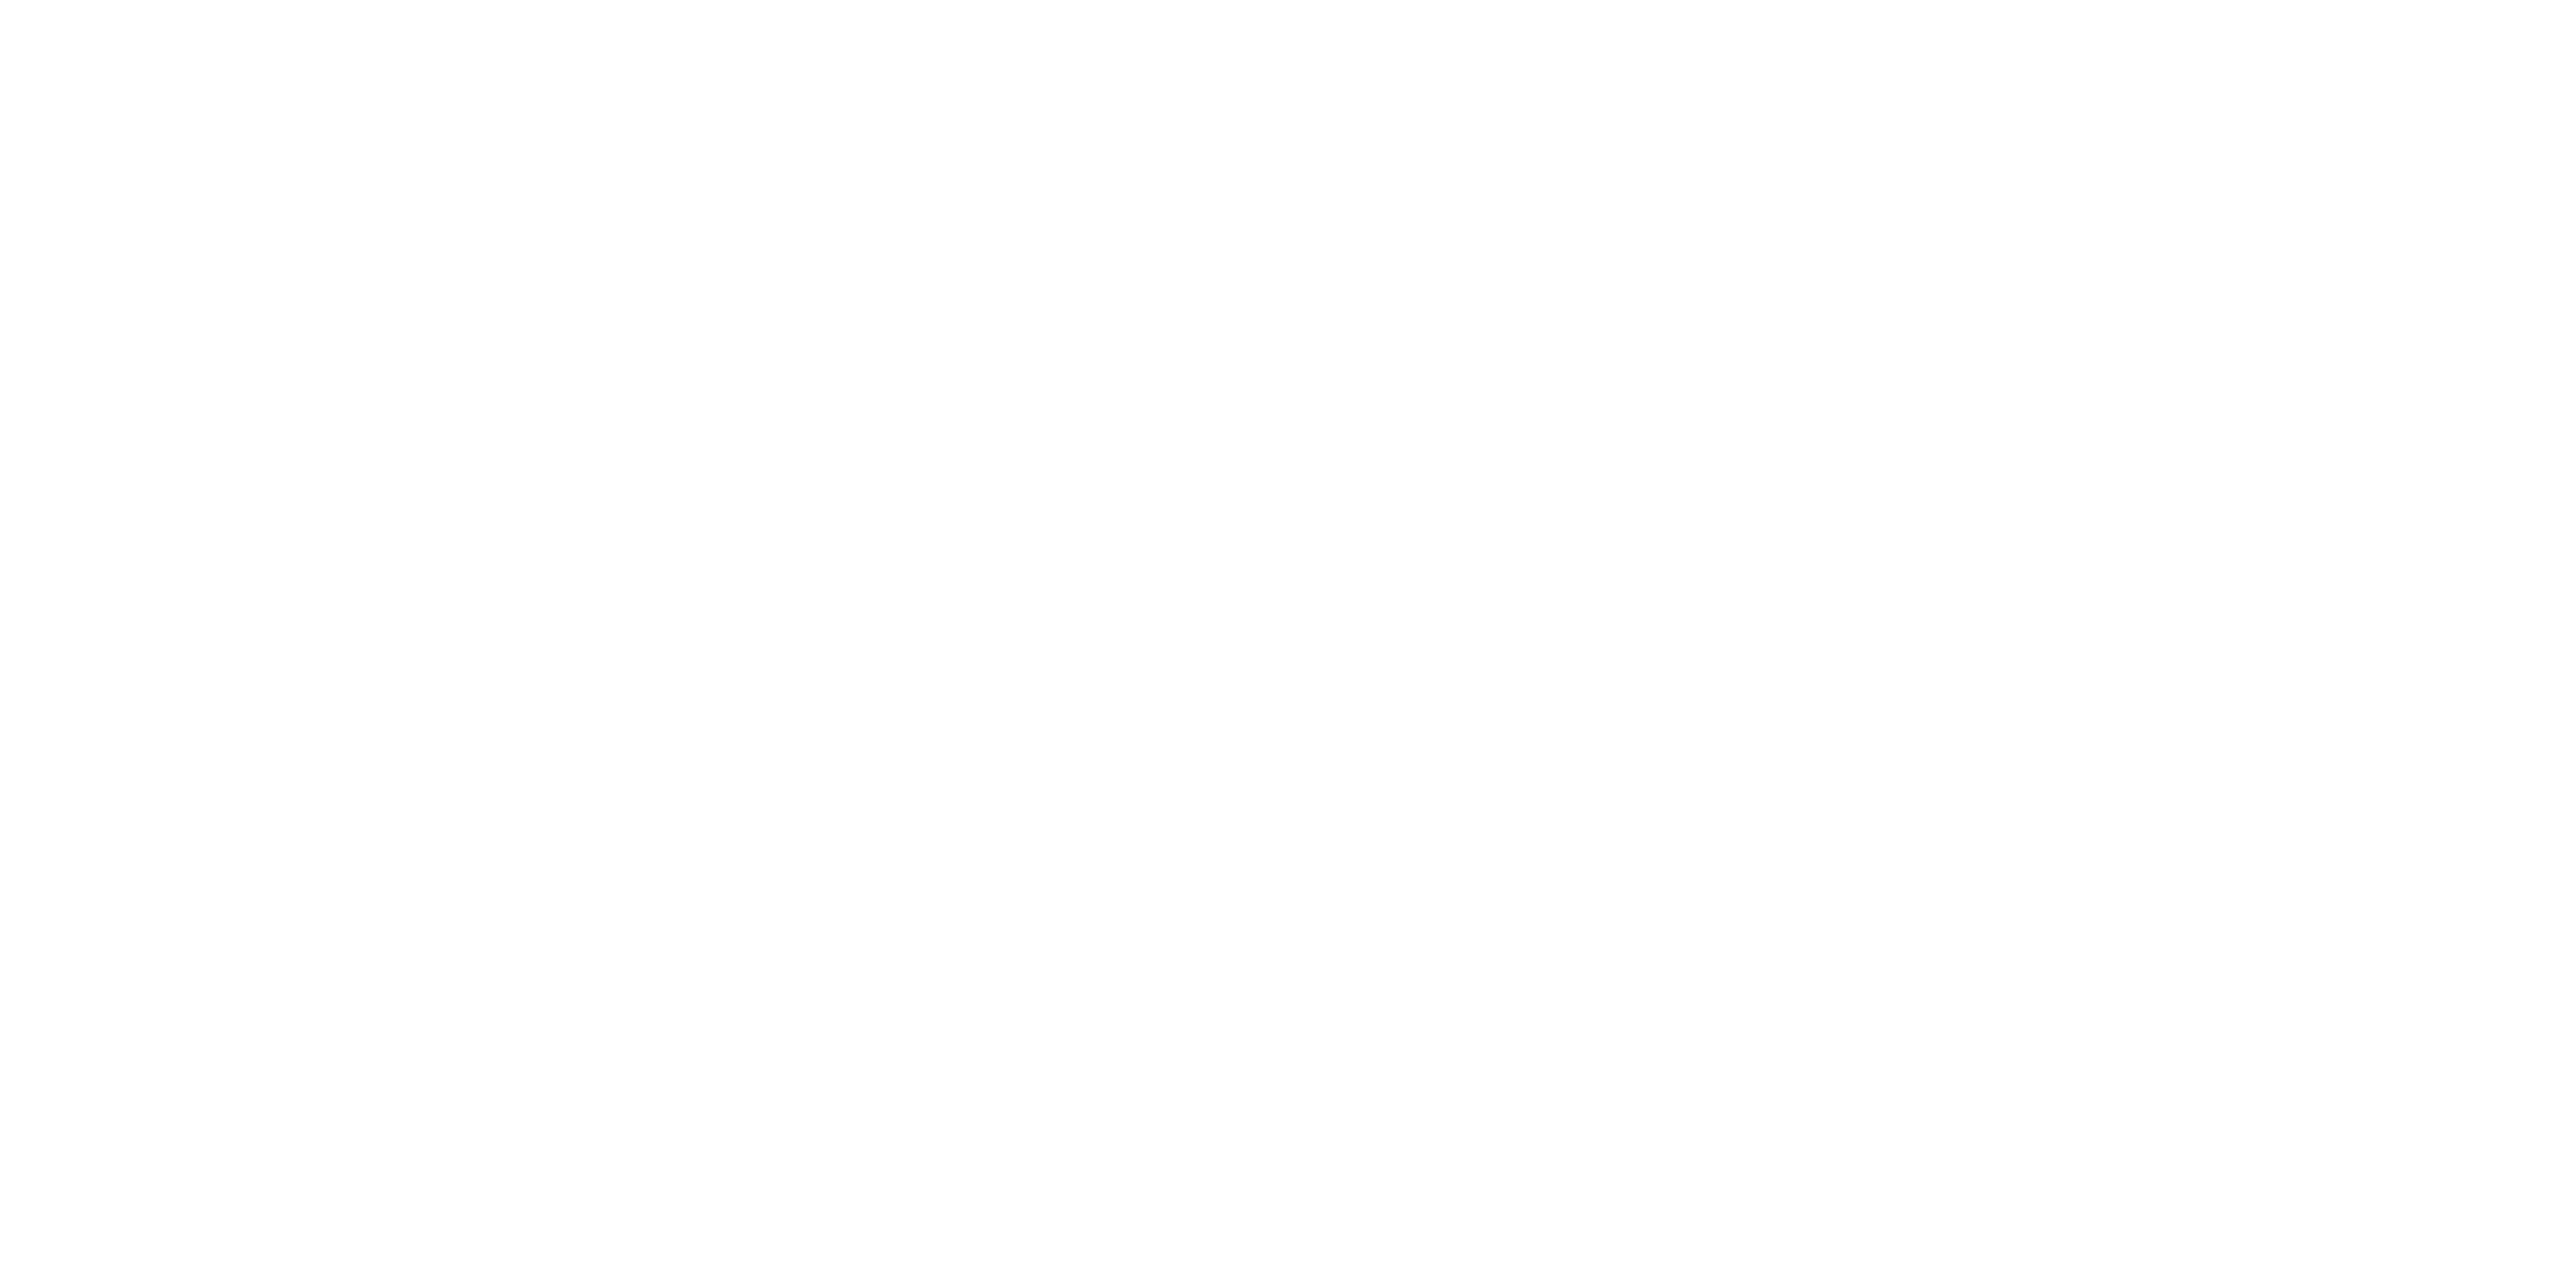

Done


<IPython.core.display.Javascript object>


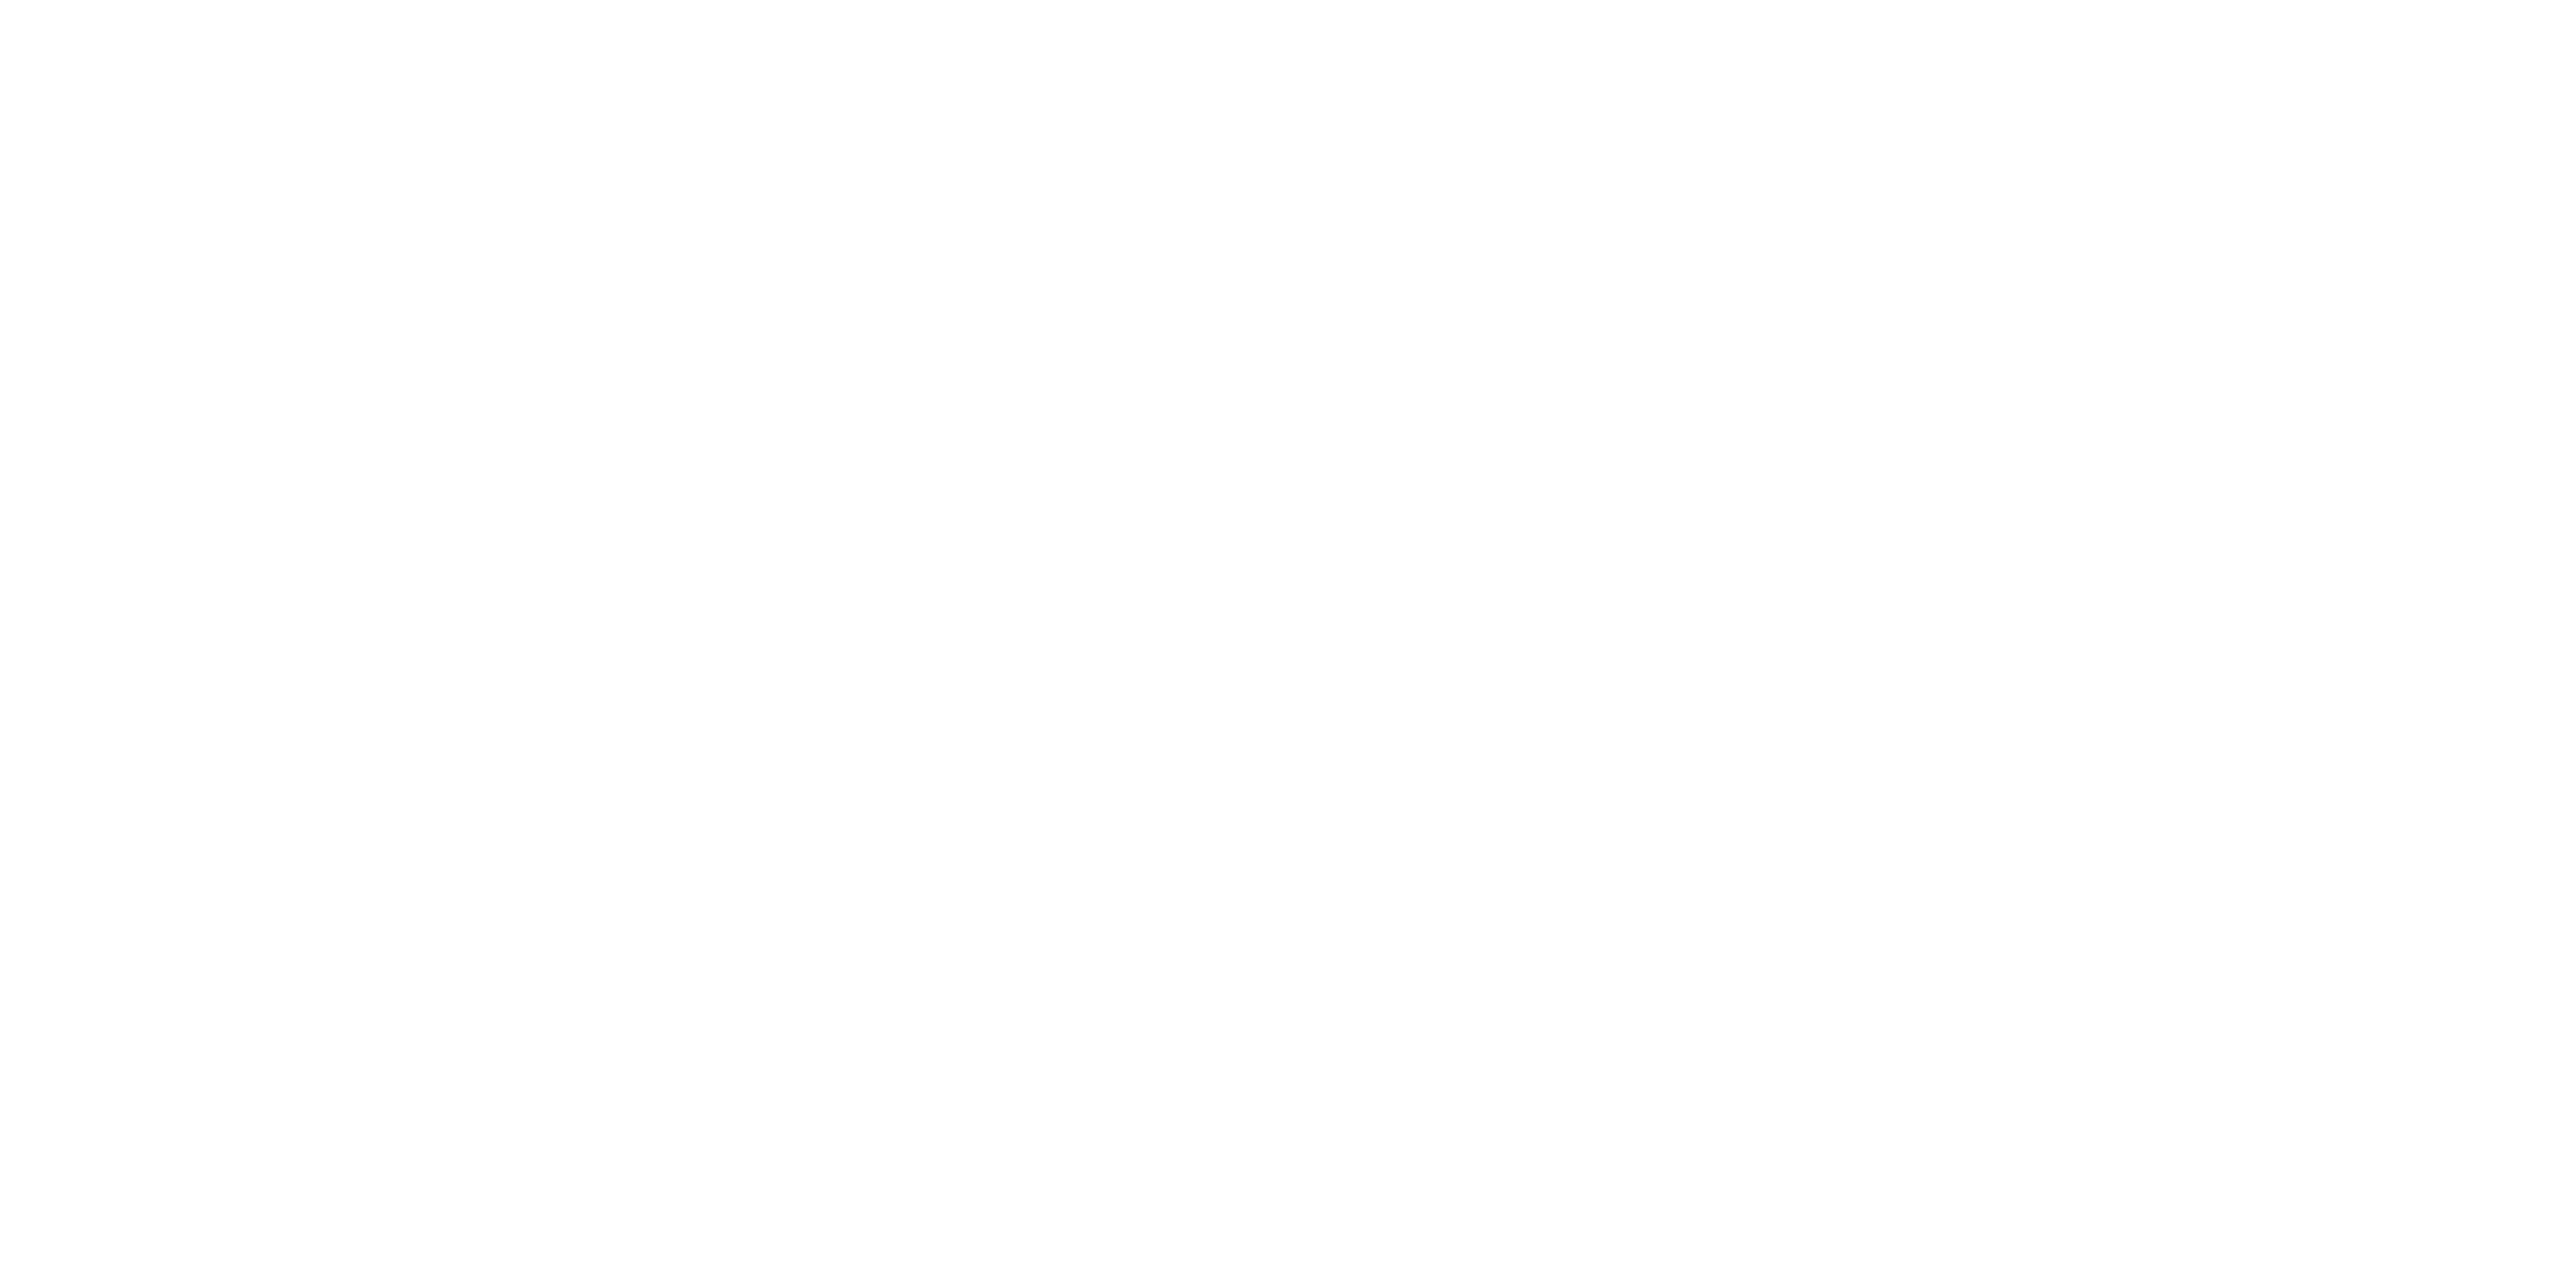

In [126]:
## 2D scatterplots: 
%matplotlib notebook
import matplotlib.pyplot as plt

# Create data
x = data['IMU A1']
y = data['IMU G3']
area = np.pi*3

colors = []
no_misc = []
for i in range(0,n):
    #if data_y[i] == 'MISC': 
        #colors.append("yellow")
    if data_y[i] == 'PADDLING':
         colors.append("green")
    if data_y[i] == 'SURFING': 
        colors.append("blue")
    if data_y[i] == 'FLOATING': 
        colors.append("red")

# Plot
print("Plotting...")
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
#plt.title('')
plt.xlabel('IMU A1')
plt.ylabel('IMU G3')
plt.show()
print("Done")


Plotting...
['MISC' 'MISC' 'MISC' ... 'MISC' 'MISC' 'MISC']
9378


<IPython.core.display.Javascript object>


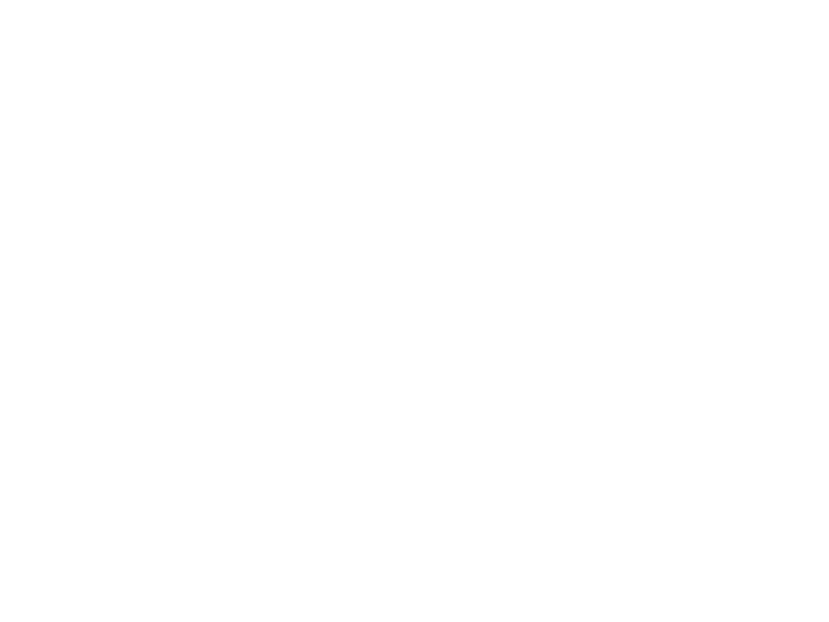

Done


<IPython.core.display.Javascript object>


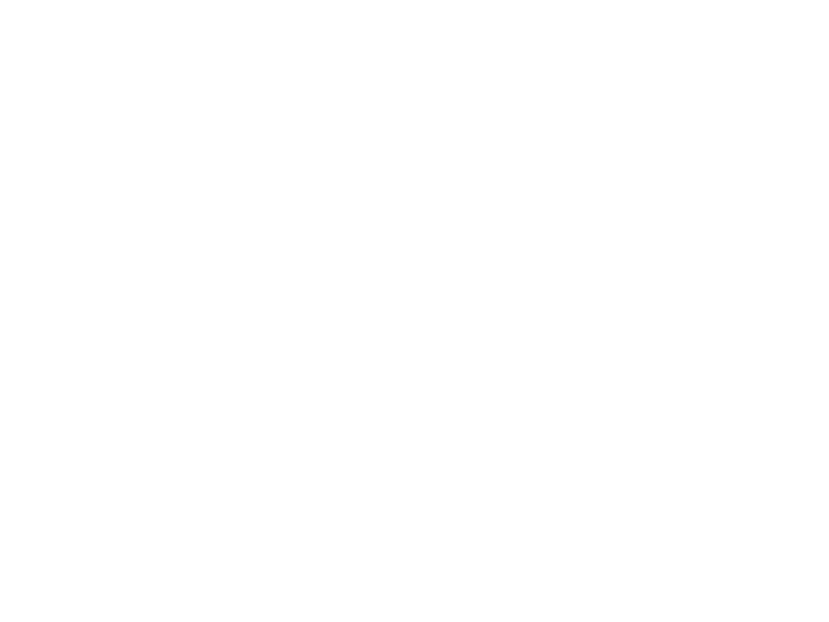

In [127]:
#Same visualization as above but including MISC values. 
%matplotlib notebook


from mpl_toolkits.mplot3d import Axes3D

print("Plotting...")

data = simple_misc_multiclass_df.copy()

data_y = data.loc[:,'simple_label'].values
#y = y.tolist()
print(data_y)

n = len(data_y)
print(n)

colors = []
for i in range(0,n):
    if data_y[i] == 'FLOATING': 
        colors.append("red")
    if data_y[i] == 'PADDLING':
         colors.append("green")
    if data_y[i] == 'SURFING': 
        colors.append("blue")
    if data_y[i] == 'MISC': 
        colors.append("yellow")
        
        
        
#print(colors)



td_plot1 = plt.figure(figsize=[6.4, 4.8]).gca(projection='3d')
td_plot1.scatter(data['IMU A1'], data['IMU A2'], data['IMU A3'], c=colors)
td_plot1.set_xlabel('IMU A1')
td_plot1.set_ylabel('IMU A2')
td_plot1.set_zlabel('IMU A3')

scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c="red", marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c="green", marker = 'o')
scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c="blue", marker = 'o')
scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c="yellow", marker = 'o')


td_plot1.legend([scatter1_proxy, scatter2_proxy, scatter3_proxy], ["FLOATING", "PADDLING", "SURFING", "MISC"], numpoints = 1)


plt.show();

print("Done")

Plotting...


<IPython.core.display.Javascript object>


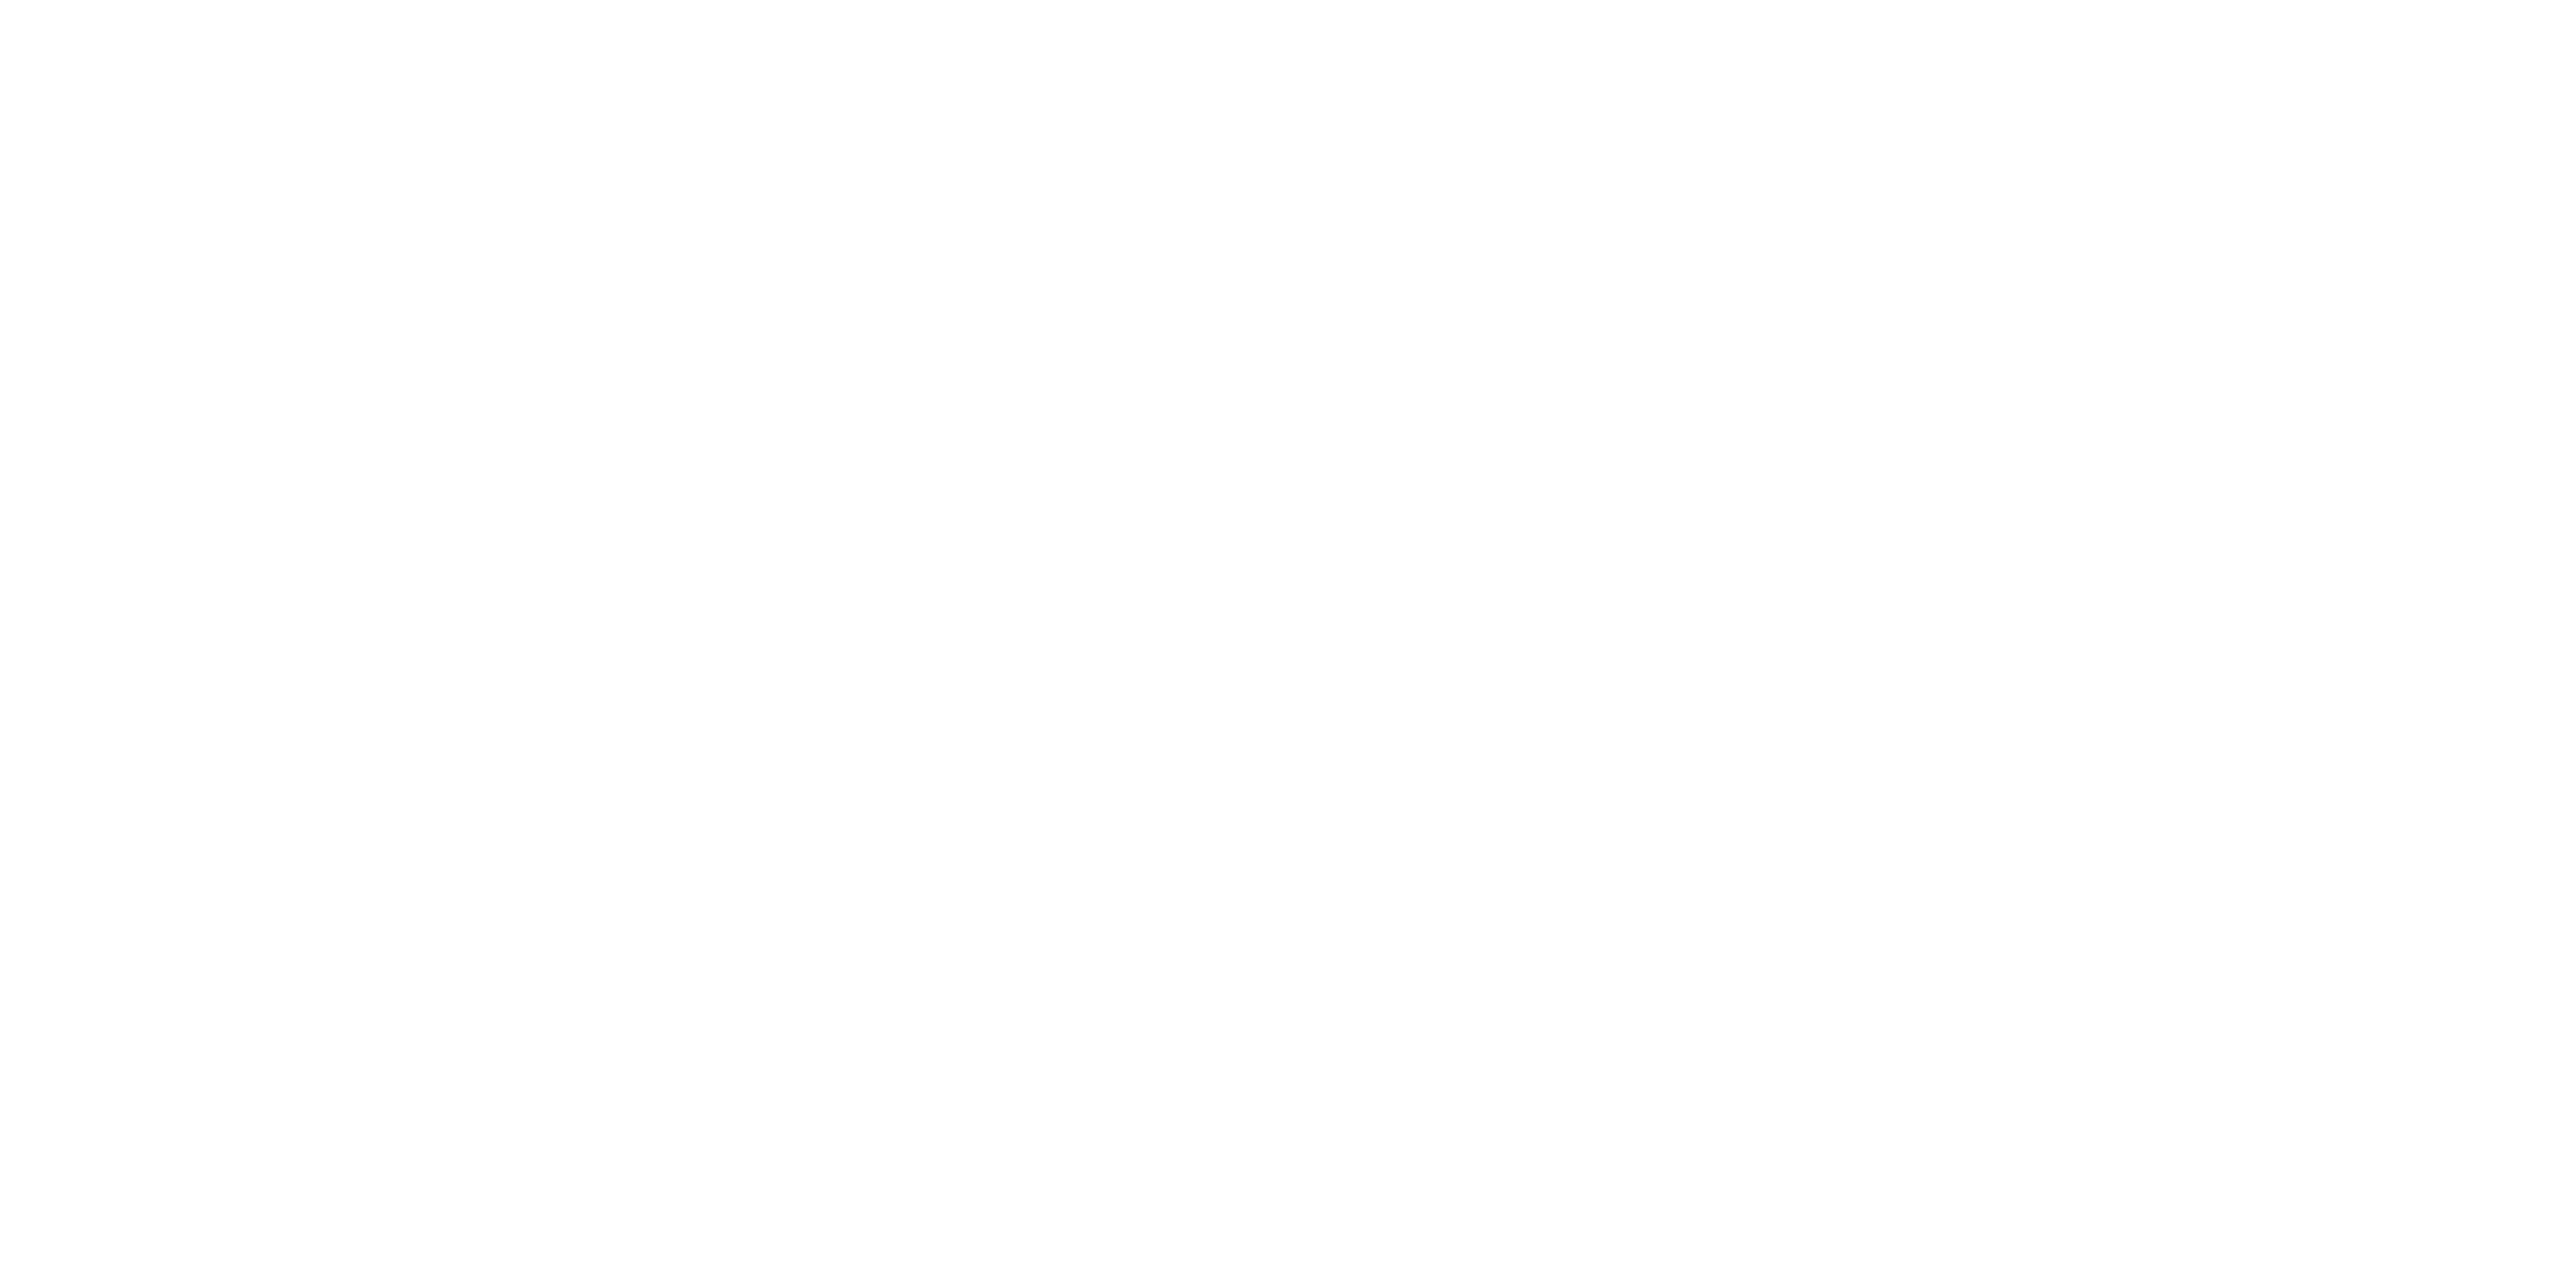

Done


<IPython.core.display.Javascript object>


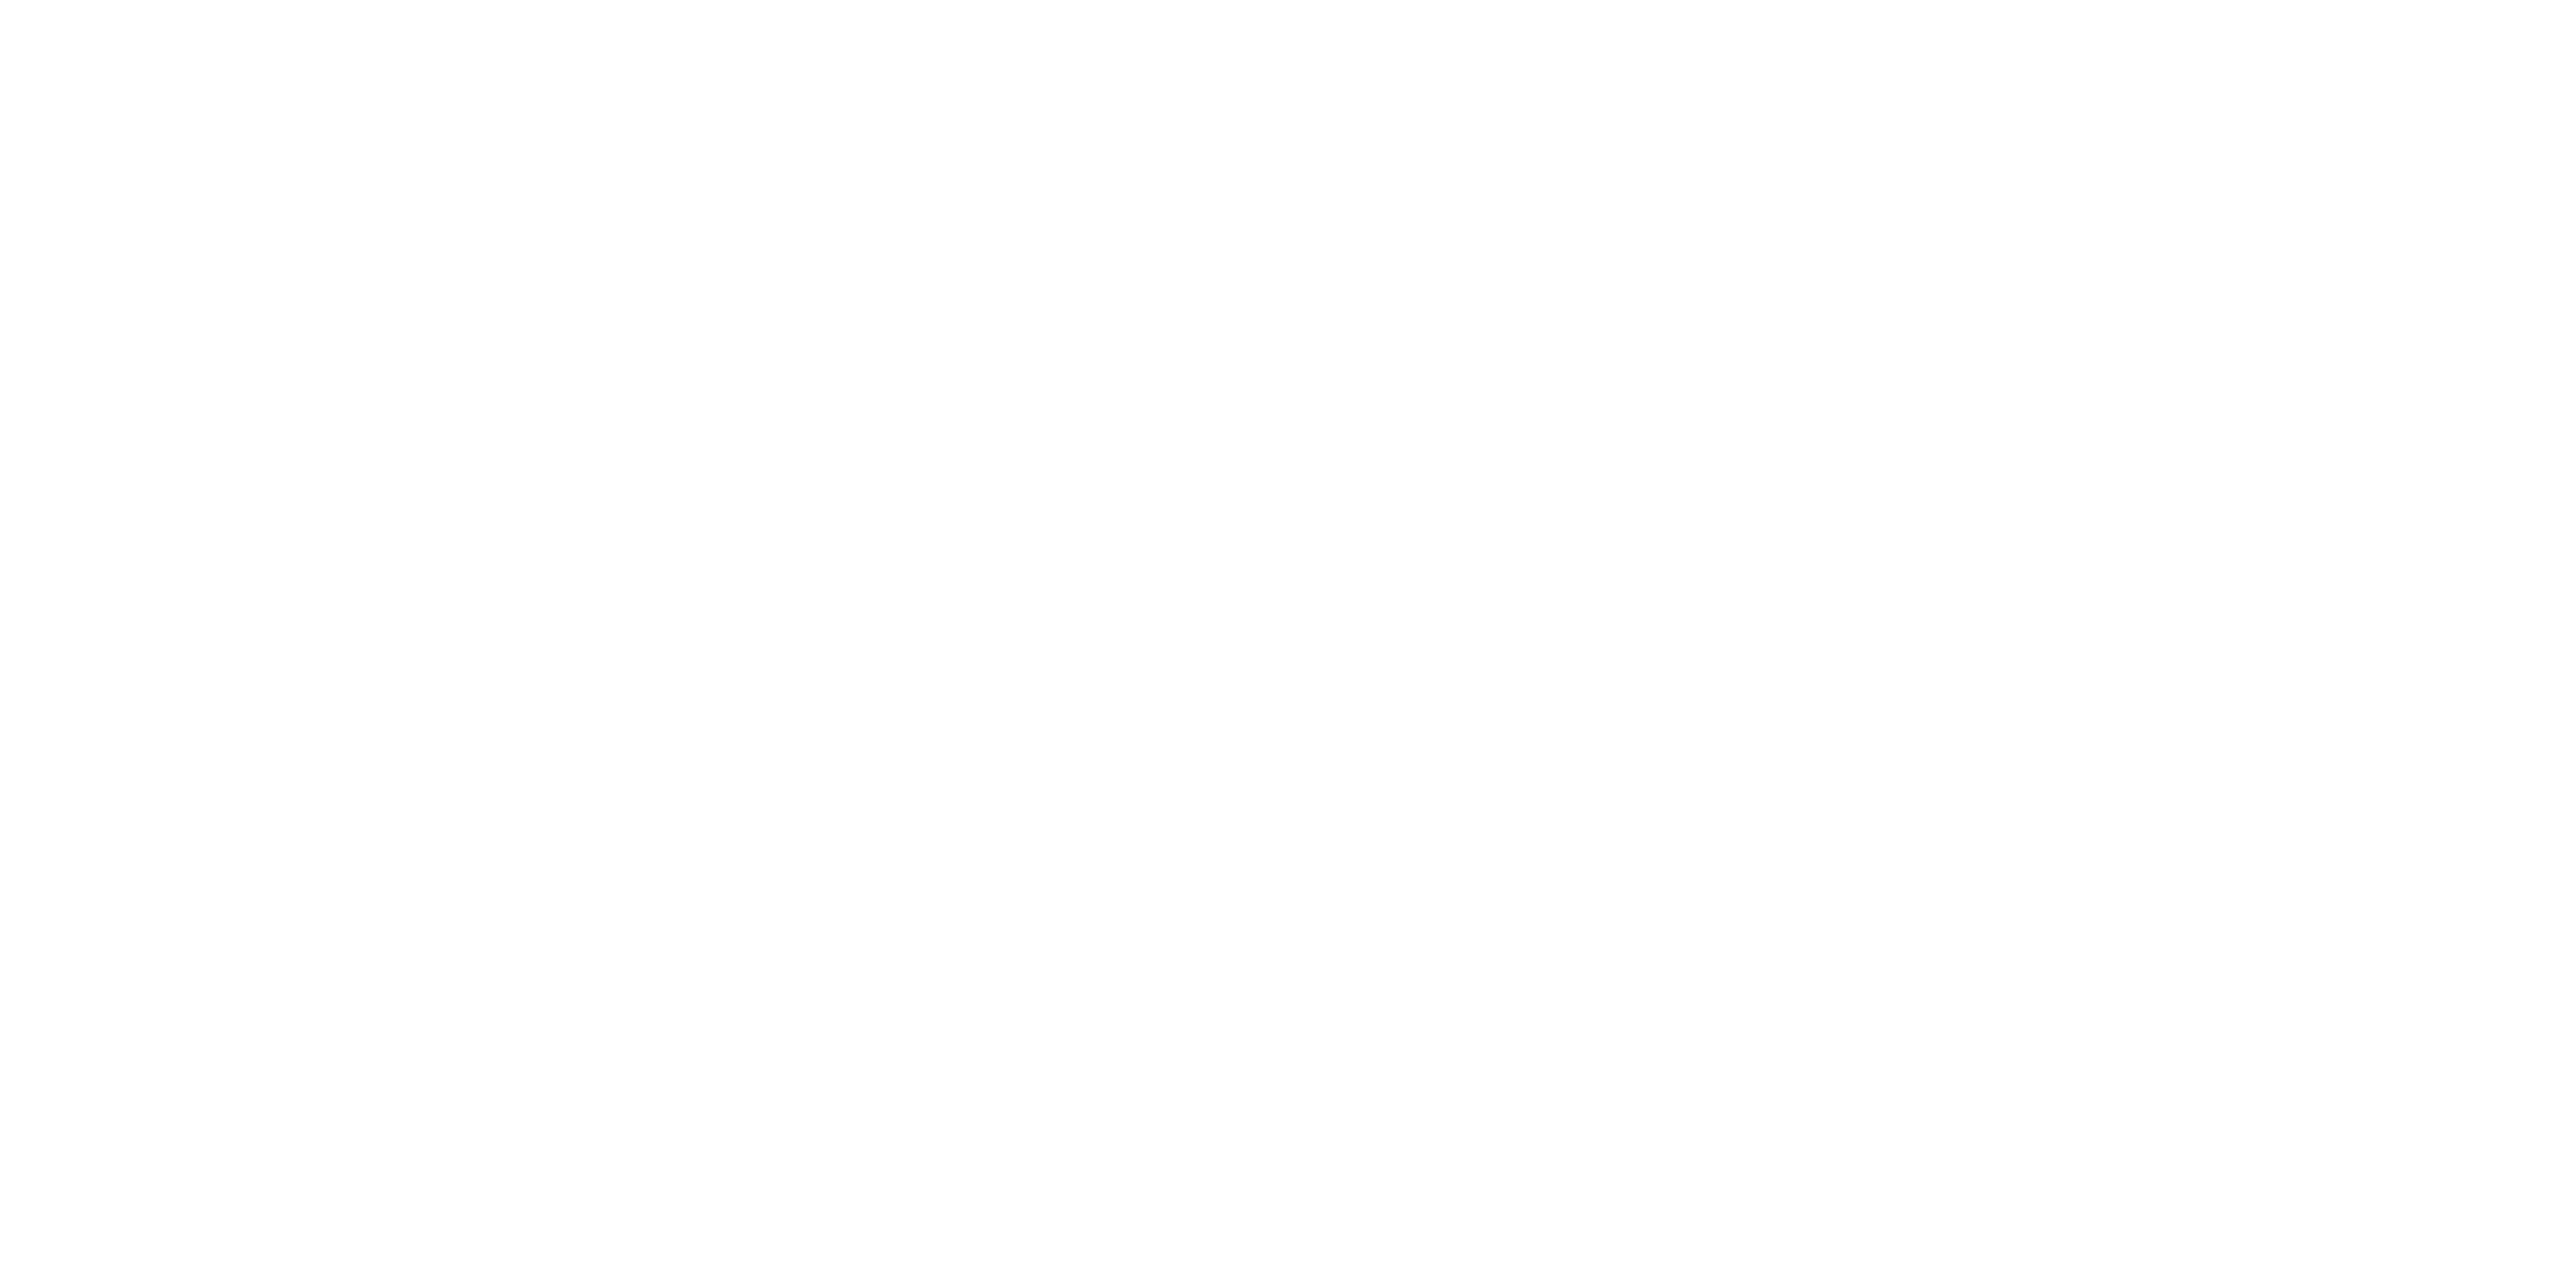

In [128]:
## 2D scatterplots: 
%matplotlib notebook
import matplotlib.pyplot as plt

# Create data
x = data['IMU A1']
y = data['IMU G3']
area = np.pi*3


# Plot
print("Plotting...")
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
#plt.title('')
plt.xlabel('IMU A1')
plt.ylabel('IMU G3')
plt.show()
print("Done")

## Pre-Processing Steps for Multinomial Logistic Regression

In [361]:
#If we don't want to include MISC values: 
simple_multi_dataset = simple_multiclass_df.copy()
print(simple_multi_dataset.columns)

simple_multi_dataset.head(10)

#If we do want to include MISC values: 
#simple_multi_dataset = simple_misc_multiclass_df.copy()

Index(['IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1',
       'IMU M2', 'IMU M3', 'simple_label'],
      dtype='object')


IMU A1     IMU A2     IMU A3     IMU G1  \
ride_id UTC                                                                   
15692   2018-11-09 19:17:41.238  -0.344538  11.637728   2.775445  -2.195122   
        2018-11-09 19:17:41.502   1.894959  10.087307   0.861345  16.585366   
        2018-11-09 19:17:41.733   1.435575  10.699819   1.607844   1.829268   
        2018-11-09 19:17:41.997  -4.402430   8.288053   1.952382  -7.317073   
        2018-11-09 19:17:42.228   1.856677  11.465459   2.392625   3.902439   
        2018-11-09 19:17:42.492 -14.987403  21.839881  10.259576 -32.439024   
        2018-11-09 19:17:42.756   0.229692   8.307194   0.363679  57.073171   
        2018-11-09 19:17:42.987   2.450048  12.652201  -1.186742  28.414634   
        2018-11-09 19:17:43.251   2.048087   8.364617   3.273111  -0.365854   
        2018-11-09 19:17:43.482  -0.478525  10.604114   0.727358 -12.804878   

                                    IMU G2     IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                                     
15692   2018-11-09 19:17:41.238  -5.000000   8.414634   -37.0  -165.0   197.0   
        2018-11-09 19:17:41.502  -4.146341   7.560976   -45.0  -163.0   201.0   
        2018-11-09 19:17:41.733  -6.219512  -4.390244   -42.0  -158.0   216.0   
        2018-11-09 19:17:41.997  -6.097561   3.292683   -41.0  -165.0   195.0   
        2018-11-09 19:17:42.228  -8.170732  20.121951   -46.0  -166.0   186.0   
        2018-11-09 19:17:42.492   0.121951   2.195122   -47.0  -165.0   175.0   
        2018-11-09 19:17:42.756  22.682927 -15.487805   -48.0  -180.0   150.0   
        2018-11-09 19:17:42.987 -17.317073   5.853659   -50.0  -160.0   210.0   
        2018-11-09 19:17:43.251   5.975610  10.853659   -50.0  -166.0   206.0   
        2018-11-09 19:17:43.482  -0.365854   4.756098   -56.0  -174.0   194.0   

                                simple_label  
ride_id UTC                                   
15692   2018-11-09 19:17:41.238     PADDLING  
        2018-11-09 19:17:41.502     PADDLING  
        2018-11-09 19:17:41.733     PADDLING  
        2018-11-09 19:17:41.997     PADDLING  
        2018-11-09 19:17:42.228     PADDLING  
        2018-11-09 19:17:42.492     PADDLING  
        2018-11-09 19:17:42.756     PADDLING  
        2018-11-09 19:17:42.987     PADDLING  
        2018-11-09 19:17:43.251     PADDLING  
        2018-11-09 19:17:43.482     PADDLING

In [362]:
#Need to scale all feature values



In [398]:
#Need to split into testing and training sets

#X = simple_multi_dataset.iloc[:, :-1].values  #selects everything until the last column listed
#y = simple_multi_dataset.iloc[:, -1].values   #selects the last column 

X = simple_misc_multiclass_df.iloc[:, :-1].values  #selects everything until the last column listed
y = simple_misc_multiclass_df.iloc[:, -1].values   #selects the last column 

X = simple_multi_dataset.iloc[:, :-1].values
y = simple_multi_dataset.iloc[:, -1].values

print("X.shape:", X.shape)
print("y.shape:", y.shape)

print("y:", y)

count_y_float = 0
count_y_paddle = 0
count_y_surf = 0

for y_val in y: 
    if y_val == "FLOATING":
        count_y_float+=1
    if y_val == "PADDLING":
        count_y_paddle+=1
    if y_val == "SURFING":
        count_y_surf+=1

print("Num floating: ", count_y_float)
print("Num paddling: ", count_y_paddle)
print("Num surfing: ", count_y_surf)

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

#print("first few y_train values:", y_train[0:10])
#print("first few y_test values:", y_test[0:10])



X.shape: (6680, 9)
y.shape: (6680,)
y: ['PADDLING' 'PADDLING' 'PADDLING' ... 'SURFING' 'SURFING' 'SURFING']
Num floating:  4312
Num paddling:  2188
Num surfing:  180
x_train shape: (6012, 9)
y_train shape: (6012,)
x_test shape: (668, 9)
y_test shape: (668,)


### Setting up the dataset: 

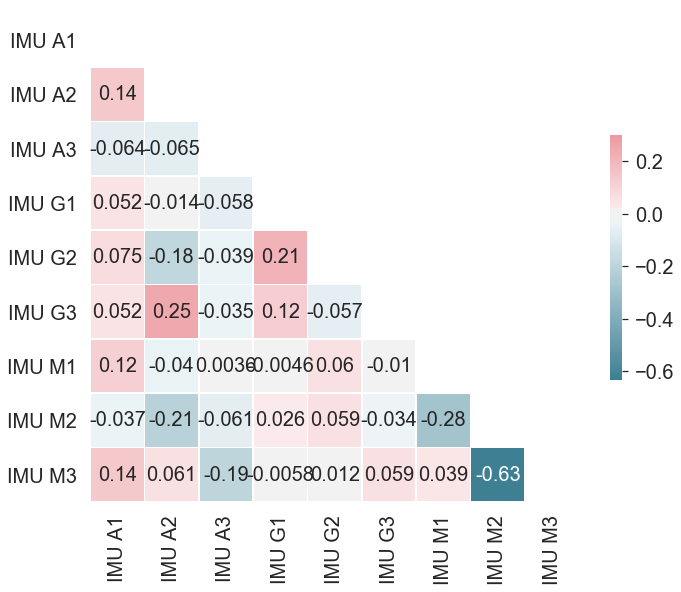

In [399]:
#Display Correlation Features: 
import seaborn as sns

d = simple_multi_dataset
#d = simple_misc_multiclass_df


#Need to bin the data for the correlation matrix: 
#IMU A1 = bin(IMU A1)
#etc.


# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#f,ax = plt.subplots(figsize=(18, 18))
#sns.heatmap(X, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [400]:
#Need to balance labels with SMOTE, ADASYN
from imblearn.over_sampling import SMOTE, ADASYN

X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)


#sm = SMOTE(sampling_strategy='all', random_state=12, ratio=1.0)
#X_train_res, y_train_res = sm.fit_sample(X_train, y_train)  #oversample on only the training data, after splitting the data initially into training and testing sets

#X_train, y_train = SMOTE().fit_resample(X_train, y_train)
#X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print(X_train_res.shape)
print(y_train_res.shape)

count_y_float = 0
count_y_paddle = 0
count_y_surf = 0

for y in y_train_res: 
    if y == "FLOATING":
        count_y_float+=1
    if y == "PADDLING":
        count_y_paddle+=1
    if y == "SURFING":
        count_y_surf+=1
        
print(count_y_float)
print(count_y_paddle)
print(count_y_surf)


print("Done")


(11598, 9)
(11598,)
3866
3866
3866
Done


## Multinomial Logistic Regression on Unfiltered IMU Signals

In [401]:
 # Train multinomial logistic regression model using SMOTE
    
from sklearn import linear_model
from sklearn import metrics



#Using SMOTE: 
print("Using SMOTE: \n")
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train_res, y_train_res)
print("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train_res, mul_lr.predict(X_train_res)))
print("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))
    
    
# Predicting the Test set results
y_pred = mul_lr.predict(X_test)

#Confusion matrix: C_ij is equal to the number of observations known to be in group i but predicted to be in group j.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=["FLOATING", "PADDLING", "SURFING"])
#cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=["FLOATING", "PADDLING", "SURFING", "MISC"])

print("When printing the confusion matrix, the diaganols tell us the number of correct predictions.") 
print(cm)
    
count_y_float = 0
count_y_paddle = 0
count_y_surf = 0
count_y_misc = 0

for y in y_test: 
    if y == "FLOATING":
        count_y_float+=1
    if y == "PADDLING":
        count_y_paddle+=1
    if y == "SURFING":
        count_y_surf+=1
    if y == "MISC":
        count_y_misc+=1
        
print("Float: ", count_y_float)
print("Paddle: ", count_y_paddle)
print("Surf: ", count_y_surf)
#print("Misc: ", count_y_misc)

#classes = ["FLOATING", "PADDLING", "SURFING", "MISC"]
classes = ["FLOATING", "PADDLING", "SURFING"]




Using SMOTE: 

Multinomial Logistic regression Train Accuracy ::  0.5906190722538369
Multinomial Logistic regression Test Accuracy ::  0.47754491017964074
When printing the confusion matrix, the diaganols tell us the number of correct predictions.
[[186 128 132]
 [ 34 118  46]
 [  7   2  15]]
Float:  446
Paddle:  198
Surf:  24


Plotting CM ...
Multinomial LR confusion matrix, without normalization
[[186 128 132]
 [ 34 118  46]
 [  7   2  15]]
Multinomial LR normalized confusion matrix
[[0.41704036 0.28699552 0.29596413]
 [0.17171717 0.5959596  0.23232323]
 [0.29166667 0.08333333 0.625     ]]


/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


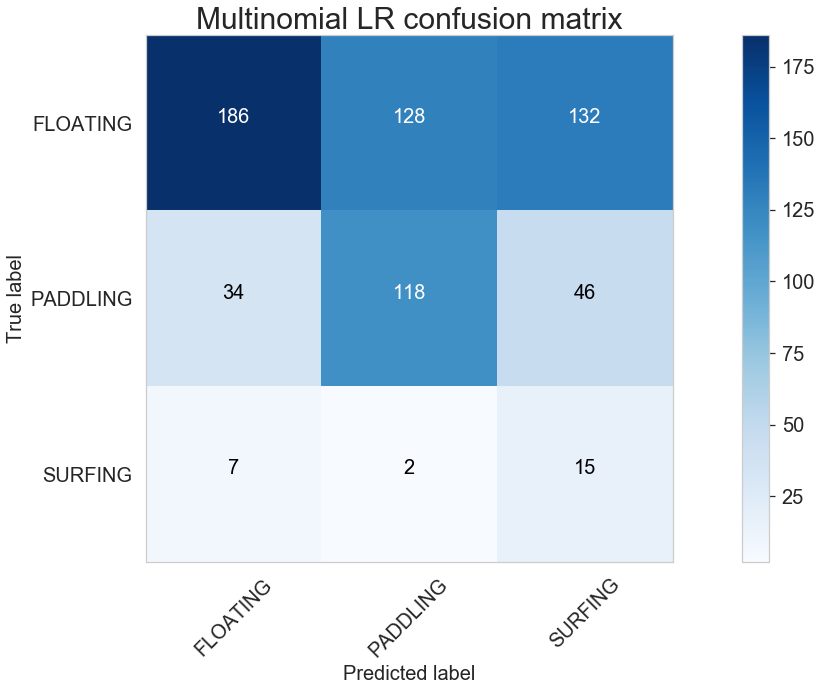

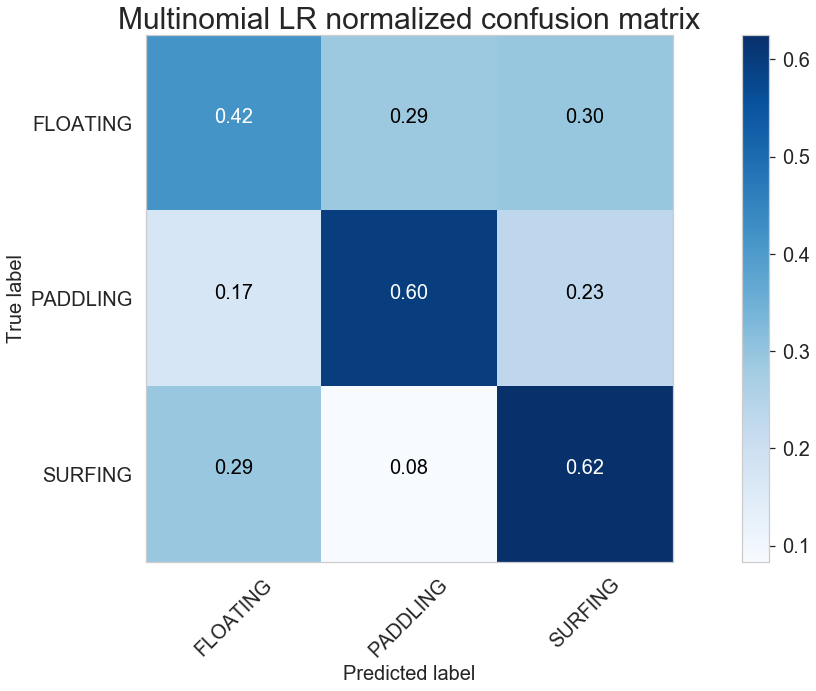

In [402]:
%matplotlib inline

# import packages
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20


#axes.titlesize : 24
#axes.labelsize : 20
#lines.linewidth : 3
#lines.markersize : 10
#xtick.labelsize : 16
#ytick.labelsize : 16

class_names = ["FLOATING", "PADDLING", "SURFING"]

print("Plotting CM ...")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Multinomial LR normalized confusion matrix")
    else:
        print('Multinomial LR confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.grid('off')
plot_confusion_matrix(cm, classes=class_names,
                      title='Multinomial LR confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Multinomial LR normalized confusion matrix')

plt.grid('off')

plt.show()

In [403]:
# 10-cross Fold
from sklearn.model_selection import cross_val_score
score = cross_val_score(estimator = mul_lr, X = X_test, y = y_test, cv = 12)
print(score)

[0.66666667 0.64912281 0.76785714 0.625      0.69642857 0.69642857
 0.78181818 0.76363636 0.67272727 0.74545455 0.70909091 0.67272727]


In [408]:
print("Average score from cross validation scores:")
print(sum(score)/len(score))

Average score from cross validation scores:
0.7039131920710867


In [405]:
from sklearn.metrics import classification_report, confusion_matrix 
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

    FLOATING       0.82      0.42      0.55       446
    PADDLING       0.48      0.60      0.53       198
     SURFING       0.08      0.62      0.14        24

   micro avg       0.48      0.48      0.48       668
   macro avg       0.46      0.55      0.41       668
weighted avg       0.69      0.48      0.53       668



In [409]:
from sklearn import metrics
print("Multiclass LR Train Accuracy :: ", metrics.accuracy_score(y_train, mul_lr.predict(X_train)))
print("Multiclass LR Test Accuracy :: ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))

Multiclass MLP Train Accuracy ::  0.7262142381902861
Multiclass MLP Test Accuracy ::  0.7305389221556886


# Training multinomial logistic regression model *without* using SMOTE


In [406]:

print("\nNot using SMOTE: \n")
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, y_train)
print("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, mul_lr.predict(X_train)))
print("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))

# Predicting the Test set results
y_pred = mul_lr.predict(X_test)

#Confusion matrix: C_ij is equal to the number of observations known to be in group i but predicted to be in group j.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=["FLOATING", "PADDLING", "SURFING"])
#cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=["FLOATING", "PADDLING", "SURFING", "MISC"])

print("When printing the confusion matrix, the diaganols tell us the number of correct predictions.") 
print(cm)

#Print score:
from sklearn.model_selection import cross_val_score
print(mul_lr.score(X_test, y_test))



Not using SMOTE: 

Multinomial Logistic regression Train Accuracy ::  0.7262142381902861
Multinomial Logistic regression Test Accuracy ::  0.7305389221556886
When printing the confusion matrix, the diaganols tell us the number of correct predictions.
[[408  38   0]
 [118  80   0]
 [ 21   3   0]]
0.7305389221556886


Plotting CM ...
Multinomial LR confusion matrix, without normalization
[[408  38   0]
 [118  80   0]
 [ 21   3   0]]
Multinomial LR normalized confusion matrix
[[0.91479821 0.08520179 0.        ]
 [0.5959596  0.4040404  0.        ]
 [0.875      0.125      0.        ]]


/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


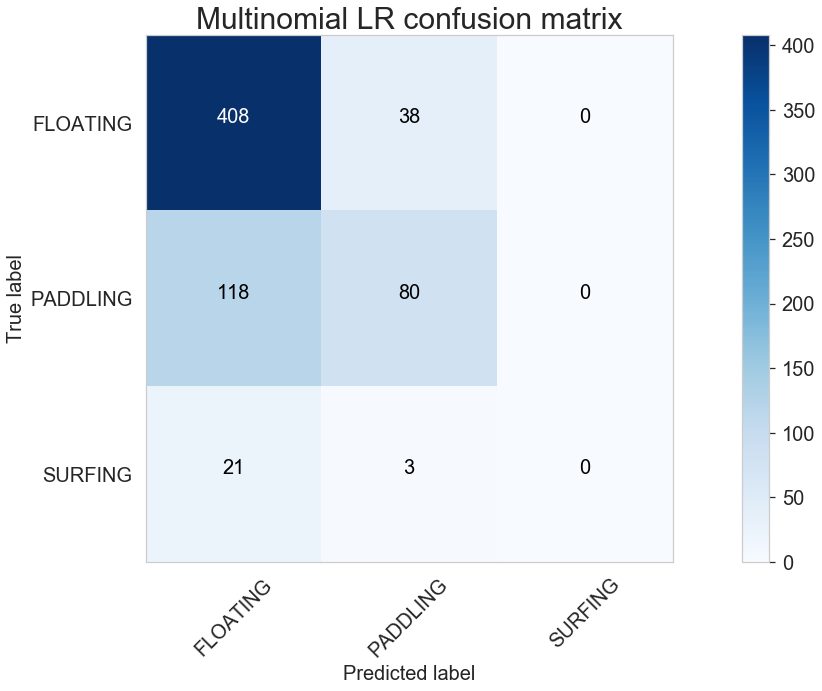

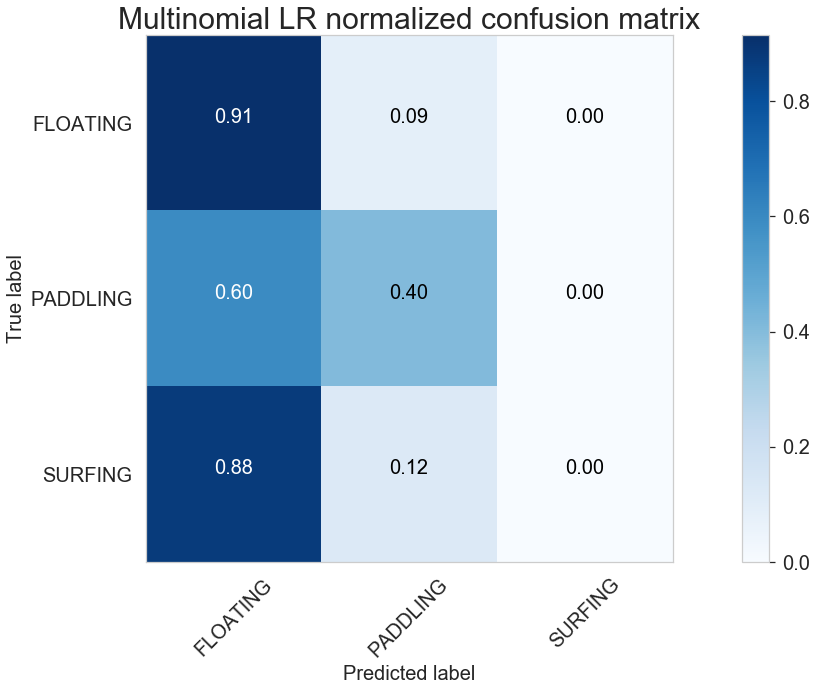

In [407]:
%matplotlib inline

# import packages
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20


#axes.titlesize : 24
#axes.labelsize : 20
#lines.linewidth : 3
#lines.markersize : 10
#xtick.labelsize : 16
#ytick.labelsize : 16

class_names = ["FLOATING", "PADDLING", "SURFING"]

print("Plotting CM ...")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Multinomial LR normalized confusion matrix")
    else:
        print('Multinomial LR confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.grid('off')
plot_confusion_matrix(cm, classes=class_names,
                      title='Multinomial LR confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Multinomial LR normalized confusion matrix')

plt.grid('off')

plt.show()

In [388]:
# 10-cross Fold
from sklearn.model_selection import cross_val_score
score = cross_val_score(estimator = mul_lr, X = X_test, y = y_test, cv = 12)
print(score)

[0.46153846 0.44871795 0.61538462 0.55128205 0.5        0.54545455
 0.50649351 0.51315789 0.44736842 0.52631579 0.47368421 0.54666667]


In [389]:
print("Average score from confusion matrix:")
print(sum(score)/len(score))

Average score from confusion matrix:
0.5113386759439392
